<a href="https://colab.research.google.com/github/cgpilapanta/timeseries/blob/main/TEG_Cap_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CAPÍTULO 03. ANÁLISE TEMPORAL**
---
*   Autor: Christian G. Pilapanta A.
*   Data : Setembro de 2024
*   Lotação: Departamento de Geomática - UFPR / Laboratorio de Geodésia Espacial e Hidrografia

---

**Definição do entorno de trabalho e Importação de dados**

In [151]:
#Bibliotecas de Python necessárias para rodar o código
import pandas as pd
import numpy as np
import seaborn as sns
import pickle as pickle
import scipy.stats as st
import scipy.signal as signal
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Eliminar alertas por versão
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [160]:
# Importar (clonar) repósitorio de GitHub
!rm -r timeseries
!git clone https://github.com/cgpilapanta/timeseries.git

Cloning into 'timeseries'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 267 (delta 4), reused 0 (delta 0), pack-reused 254 (from 1)
Receiving objects: 100% (267/267), 33.22 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (105/105), done.


## **3.1. Modelo geral e propriedades básicas**

### **3.1.1. Sistema dinâmico**

Obtida a série temporal $Z\left( t_{1} \right),...,Z\left( t_{n} \right)$, modelos **probabilísticos** ou **estocásticos** são construídos, no domínio temporal ou de frequências, com o intuito de tentar explicar e entender o comportamento por trás da série.

De acordo com Morettin, P. & Toloi, C. (2014), estes modelos devem ser simples e parcimoniosos (no sentido que o número de parâmetros envolvidos deve ser o menor possível) e, se possível, sua utilização não deve apresentar dificuldades às pessoas interessadas em manipulá-los.

De forma geral, muitas situações em ciências físicas, engenharia e outro tipo de ciências envolvem o conceito de *sistema dinâmico*, caracterizado por uma série de entrada $X(t)$, uma série de saída $Z(t)$ e uma função de transferência $v(t)$.

Dependendo do tipo da complexidade do modelo utilizado, o *sistema dinâmico* pode ser *linear* ou *não linear*, sendo os sitemas lineares de particular importância, devido a que permitem relacionar a saída com a entrada através de um funcional linear envolvendo $v(t)$.

Um exemplo simples deste tipo de modelo é o *modelo de função de transferência* de Box, Jenkins e Reinsel (1994):

$$Z\left ( t \right )=\sum_{\tau =0}^{\infty }v\left ( \tau  \right )X\left ( t-\tau  \right )$$

Neste caso, é de interesse (Morettin, P. & Toloi, C. 2014):

*   Estimar a função de transferência $v(t)$, conhecendo-se as séries de entrada e saída.
*   Fazer previsões da série $Z(t)$, com o conhecimento de observações da série de entrada $X(t)$.
*   Estudar o comportamento do sistema, *simulando-se* a série de entrada $X(t)$.
*   Controlar a série de saída $Z(t)$, de modo a trazê-la o mais próximo possível de um valor desejado, ajustando-se convenientemente a série de entrada $X(t)$ (i.e. filtragem de dados).

**Importante:**

*  Que características deve ter a série para poder ser expressa através de um modelo matemático (i.e. probabilístico ou estocástico)?.
*  Qual é o modelo matemático considerado como estándar na análise de séries de coordenadas? Ele é um *sistema dinâmico*?.
*  Que outro tipo de séries vocês conhecem na área das ciências geodésicas? Que modelo expressa seu comportamento?

### **3.1.2. Estacionariedade**

Uma das suposições mais frequentes que se faz a respeito de uma série temporal é a de que ela é estacionária, ou seja, ela se desenvolve no tempo aleatoriamente ao redor de uma média constante, refletindo alguma forma de equilíbrio (i.e. estabilidade). No entanto, a maior parte das séries que encontramos na prática apresentam alguma forma de não-estacionariedade.

*  No caso das séries de coordenadas das componentes horizontais (i.e. norte e este), por exemplo, elas apresentam em geral *tendências*, sendo o caso mais simples aquele em que a série flutua ao redor de uma reta, com inclinação positiva ou negativa (i.e. tendência linear - modelo de regressão estándar).

  <center><img src=https://sirgas.ipgh.org/docs/series/UFPR.png width="800"></center>

  <center>Figura 01. Serie de coordenadas. Estação de Monitoramento Continuo UFPR</center>

  <center>Fonte: sirgas.org (2024)</center>

*  No caso de uma séries sísmica ou gravimétrica, por sua vez, elas geralmente apresentam uma forma de não-estacionariedade explosiva, devido a uma força específica que impacta de forma direta o comportamento da série.

  <center><img src=https://www.researchgate.net/profile/Cheinway-Hwang/publication/225752859/figure/fig1/AS:341698430423041@1458478662324/1-Hz-data-series-recorded-during-the-period-7-13-May-2008-by-the-SG-at-HS-station-and-a.png width="600"></center>

  <center>Figura 02. Serie gravimétrica e sísmica em Taiwan</center>

  <center>Fonte: Shen, W. et. al. (2008)</center>

Uma série também pode ser estacionaria durante um período muito longo, como a série de coordenadas GPS, mas pode ser estacionária apenas em períodos muito curtos, mudando de nível e ou inclinação.

<center><img src=https://iili.io/dSLhJmF.png width="400"></center>

<center>Figura 03. Série não-estacionária quanto ao nível e inclinação.</center>

<center>Fonte: Morettin, P. & Toloi, C. (2014)</center>

Neste caso, um modelo como o ARIMA (auto-regressivo integrado de médias móveis) pode ser capaz de descrever de maneira satisfatória este tipo de séries sempre que não apresentem comportamento explosivo (i.e. não-estacionariedade homogênea).

Neste tipo de não-estacionariedade a série flutua ao redor de um nível por certo tempo, depois  de nível e flutua ao redor de um novo nível e assim por diante, ou então muda de inclinação, ou ambas as coisas.


### **3.1.3. Não-estacionariedade e diferenciação**

Como a maioria dos procedimentos de análise estatística de séries temporais supõe que estas sejam estacionárias, será necessário transformar os dados originais, se estes não formam uma série estacionaria.

A transformação (na proxima aula sera abordada detalhadamente) mais comun consiste em tomar *diferenças* sucessivas da série original, até se obter uma série estacionária.

Desta maneira:

*  A primeira diferença de $Z(t)$ é definida por:

 $$\Delta Z\left ( t \right )=Z\left ( t \right )-Z\left ( t-1 \right )$$

*  A segunda diferença é:

 $$\Delta ^{2}Z\left ( t \right )=\Delta \left [ \Delta Z\left ( t \right ) \right ]=\Delta \left [ Z\left ( t \right ) -Z\left ( t-1 \right )\right ]$$

 ou seja,

 $$\Delta ^{2}Z\left ( t \right )=Z\left ( t \right )-2Z\left ( t-1 \right )+Z\left ( t-2 \right )$$

De modo geral, a $n$-ésima diferença de $Z(t)$ é:

$$\Delta ^{n}Z\left ( t \right )=\Delta \left [ \Delta^{n-1} Z\left ( t \right ) \right ]$$

**Importante:**

* Idealmente, o papel de uma transformação é tentar estabilizar a variância em uma série temporal, onde mudanças rápidas, podem afetar a capacidade de um método de previsão de gerar resultados precisos.

* Em situações normais, será suficiente tomar uma ou duas diferenças para que a série se torne estacionária.




#### Exemplo 01. Série de coordenadas GPS
---
A. Importar conjunto de dados

In [83]:
# Definir nomes de cada coluna
header = ['Station','Date','Decimal Year','MJD','GPS Week','Week Day','Longitude','East','North','Up','Antenna Height','dE','dN','dU','corrEN','corrEU','corrNU']

# Importar arquivo de texto (dataframe Pandas)
df_gps = pd.read_csv("/content/timeseries/datasets/ngl/UFPR.tenv", names=header, delim_whitespace=True)

# Apresentar tabela de dados
df_gps.head()

,Station,Date,Decimal Year,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU
0,UFPR,96DEC14,1996.9528,50431,883,6,-49.2,-3113.36397,-2.815723e+06,925.75507,0.155,0.00098,0.00096,0.00441,0.03008,0.00245,0.07710
1,UFPR,96DEC15,1996.9555,50432,884,0,-49.2,-3113.36524,-2.815723e+06,925.75194,0.155,0.00097,0.00099,0.00439,0.00931,0.04183,0.05181
2,UFPR,96DEC16,1996.9582,50433,884,1,-49.2,-3113.36607,-2.815723e+06,925.74076,0.155,0.00100,0.00098,0.00442,-0.03754,0.00249,0.06097
3,UFPR,96DEC17,1996.9610,50434,884,2,-49.2,-3113.36379,-2.815723e+06,925.74558,0.155,0.00103,0.00105,0.00468,0.02839,0.03994,0.04081
4,UFPR,96DEC18,1996.9637,50435,884,3,-49.2,-3113.36239,-2.815723e+06,925.75661,0.155,0.00100,0.00096,0.00427,-0.03851,0.00671,0.02549


B. Plotar os dados

Text(0, 0.5, 'Up (m)')

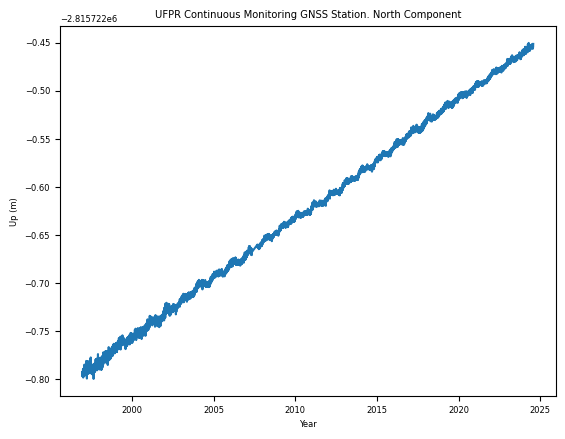

In [84]:
# Intervalos de Tempo
t = df_gps["Decimal Year"]

# Componente a ser analisada
s = df_gps["North"]

# Apresentação de resultados
plt.plot(t, s)
plt.title('UFPR Continuous Monitoring GNSS Station. North Component')
plt.xlabel("Year")
plt.ylabel("Up (m)")

C. Análise de estacionariedade (média e variância)

In [85]:
# Cálculo da média dos dados
mean_s = np.mean(s)

# Cálculo da variância dos dados
var_s = np.var(s)

print('mean=%f' % (mean_s))
print('var=%f' % (var_s))

mean=-2815722.620499
var=0.009699


D. Histograma do conjunto de dados

Text(0.5, 1.0, "Histogram with 'auto' bins")

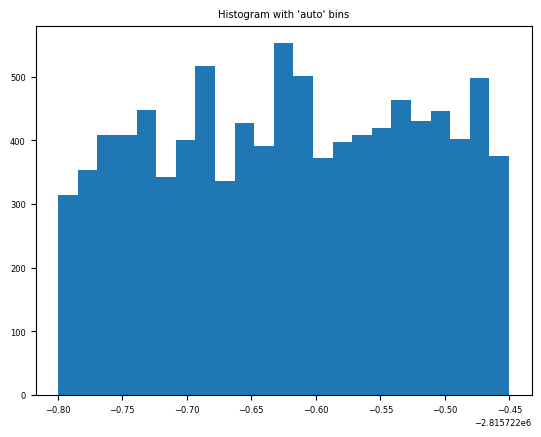

In [86]:
plt.hist(s, bins='auto')
plt.title("Histogram with 'auto' bins")

E. Normalizar os dados

Text(0, 0.5, 'Up (m)')

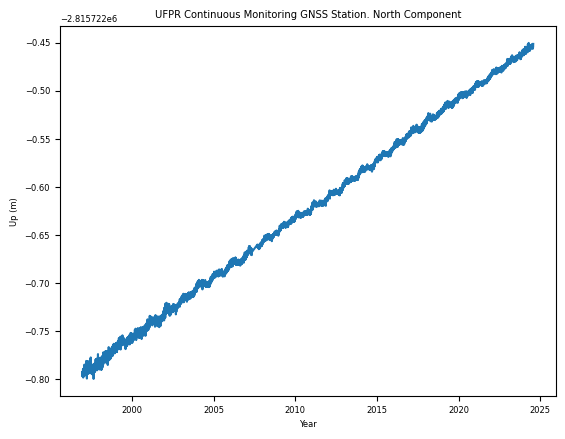

In [87]:
# Remoção da média do conjunto de dados
s_zero = s - np.mean(s)

# Apresentação de resultados
plt.plot(t, s)
plt.title('UFPR Continuous Monitoring GNSS Station. North Component')
plt.xlabel("Year")
plt.ylabel("Up (m)")

F. Calcular a média e variância dos dados normalizados

In [88]:
# Cálculo da média dos dados
mean_srz = np.mean(s_zero)

# Cálculo da variância dos dados
var_srz = np.var(s_zero)

print('mean=%f' % (mean_srz))
print('var=%f' % (var_srz))

mean=0.000000
var=0.009699


G. Histograma do conjunto de dados normalizados

Text(0.5, 1.0, "Histogram with 'auto' bins")

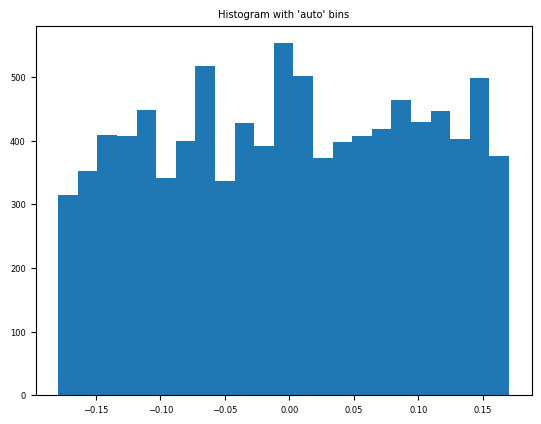

In [89]:
plt.hist(s_zero, bins='auto')
plt.title("Histogram with 'auto' bins")

H. Diferenciação do conjunto de dados normalizados (1a diferença)

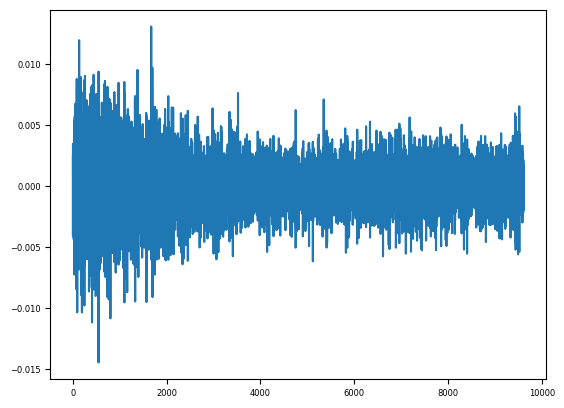

In [90]:
# Cálculo da primeira diferença
diff_01 = s_zero.diff()

# Apresentação de resultados
plt.plot(diff_01)
plt.show()

I. Calcular a média e variância dos dados diferenciados (1a diferença)

In [91]:
# Cálculo da média dos dados
mean_diff_01 = np.mean(diff_01)

# Cálculo da variância dos dados
var_diff_01 = np.var(diff_01)

print('mean=%f' % (mean_diff_01))
print('var=%f' % (var_diff_01))

mean=0.000036
var=0.000004


J. Histograma do conjunto de dados diferenciados (1a diferença)

Text(0.5, 1.0, "Histogram with 'auto' bins")

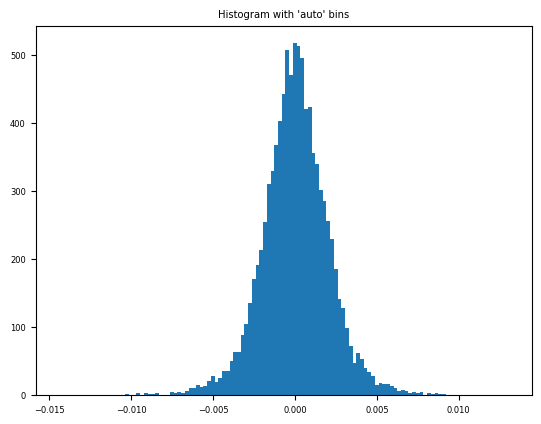

In [92]:
plt.hist(diff_01, bins='auto')
plt.title("Histogram with 'auto' bins")

K. Diferenciação do conjunto de dados (2a diferença)

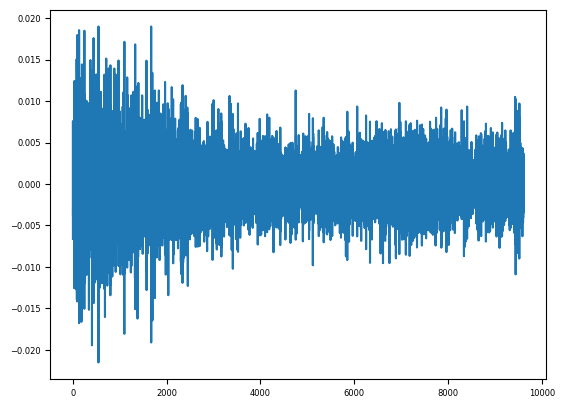

In [93]:
# Cálculo da primeira diferença
diff_02 = diff_01.diff()

# Apresentação de resultados
plt.plot(diff_02)
plt.show()

L. Cálculo da média e variância dos dados diferenciados (2a diferença)

In [94]:
# Cálculo da média dos dados
mean_diff_02 = np.mean(diff_02)

# Cálculo da variância dos dados
var_diff_02 = np.var(diff_02)

print('mean=%f' % (mean_diff_02))
print('var=%f' % (var_diff_02))

mean=-0.000000
var=0.000012


M. Histograma do conjunto de dados diferenciados (2a diferença)

Text(0.5, 1.0, "Histogram with 'auto' bins")

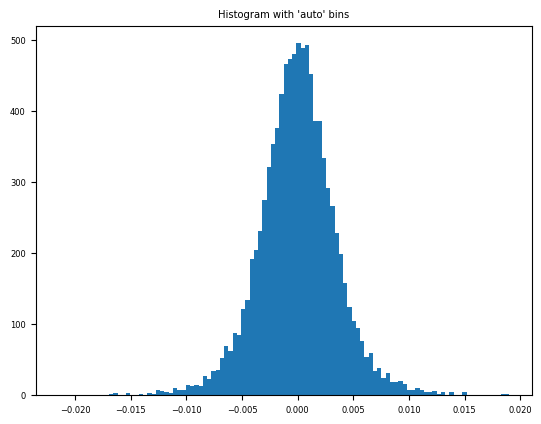

In [95]:
plt.hist(diff_02, bins='auto')
plt.title("Histogram with 'auto' bins")

### **3.1.4. Tendência, Sazonalidade e Resíduos. Decomposição Temporal**

Anteriormente, foi utilizada a *diferenciação* como uma alternativa simples para transformar uma série não estacionária a estacionária, no entanto, neste processo não foram consideradas as propriedades fundamentais da série, tais como a tendência e a sazonalidade.

A tendência e sazonalidade são os componentes não observáveis de uma série temporal que representam, respectivamente, o movimento de longo prazo e o padrão regular (queda/subida) de um determinado período do conjunto de dados. Os resíduos, por sua vez, são erros aleatórios de comportamento aleatório que não podem ser explicados deterministicamente.

Desta maneira, para uma determinada série temporal $\{Y_t\}_t$, às vezes resulta importante procurar formas de dividi-lá por meio de uma função de decomposição $f$, de forma que:

$$Y_{t}=f\left ( T_{t},S_{t},E_{t} \right )$$

onde para um determinado tempo $t$, $T_t$ e $S_t$ denotam os componentes de tendência e sazonalidade, respectivamente, e $E_t$ corresponde ao erro ou resíduos que resulta de tal decomposição.

As decomposições são úteis para uma melhor compreensão dos padrões constituintes em uma série temporal, mas não necessariamente para a geração de previsões.

De forma geral, existem dois tipos principais de métodos de decomposição de séries temporais:

1.   Decomposição aditiva: assume que os componentes são somados para formar a série temporal original.

  $$f\left ( T_{t},S_{t},E_{t} \right ):=T_{t}+S_{t}+E_{t}$$

2.   Decomposição multiplicativa: assume que os componentes são multiplicados para formar a série temporal original.

  $$f\left ( T_{t},S_{t},E_{t} \right ):=T_{t}\times S_{t}\times E_{t}$$

**Importante:**

É importante salientar que em termos de como uma decomposição é computada, geralmente se começa com a estimativa da tendência e, então, dependendo da natureza de $f$, o componente sazonal é estimado.

#### Exemplo 02. Séries de vendas e de demanda elétrica
---

A. Importação e apresentação do conjunto de dados

**1. Série de vendas de tijolos nos Estados Unidos**

In [96]:
# Import data
series_a = pd.read_excel('/content/timeseries/datasets/zemkoho/ClayBricks.xls', sheet_name ='BRICKSQ', header = 0, index_col =0, parse_dates = True)

# Plot data
series_a.plot()

**2. Série da demanda elétrica nos Estados Unidos**

In [97]:
# Import data
series_b = pd.read_excel('/content/timeseries/datasets/zemkoho/Electricity.xls', sheet_name ='Data', header = 0, index_col =0, parse_dates = True)

# Plot data
series_b.plot()

**Interpretação:**

Por inspeção, podemos ver:



*   As 2 séries apresentam uma tendência global crescente. No entanto, na venda de tijolos de argila, há uma tendência global geral com aumento constante ao longo do tempo até 1965, onde começamos a ter algumas grandes flutuações ocasionais que são difíceis de explicar e, portanto, difíceis de prever sem conhecer as causas subjacentes. Isso pode ser um reflexo de um comportamento de tendência cíclica na série temporal.
*  Claramente, a tendência e o comportamento cíclico podem ser facilmente identificados a partir dos gráficos. No entanto, ao contrário das tendências, a sazonalidade pode ser mais complicada de observar.
*  Considerando o papel importante que a identificação da sazonalidade desempenha no desenvolvimento/seleção de alguns métodos de previsão (por exemplo, suavização exponencial e métodos ARIMA), é necessário prestar atenção em como avaliá-la.
*   No caso da segunda série, é possivel ver uma série de picos e vales ocorrendo em intervalos regulares com uma crecimento explosivo.



B. Análise visual da sazonalidade das séries. Gráficos de sazonalidade

**1. Série de vendas de tijolos nos Estados Unidos**

<ipython-input-98-9e0540cfd825>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



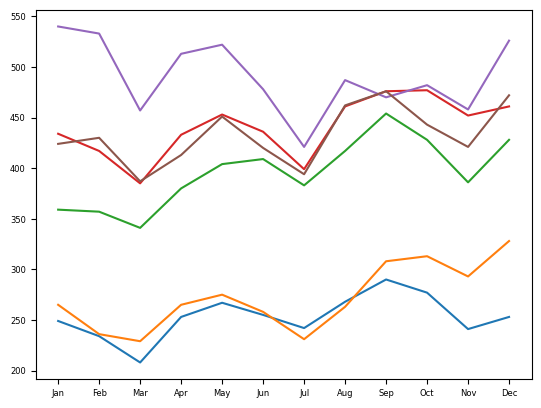

In [98]:
# Import data
series_a1 = pd.read_excel('/content/timeseries/datasets/zemkoho/ClayBricks.xls', sheet_name ='SeasonalData', header = 0, index_col =0, parse_dates = True)

# Plot data
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
months = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(x, months)
plt.plot(x, series_a1)
plt.show()

**2. Série da demanda elétrica nos Estados Unidos**

<ipython-input-99-91968d1052de>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



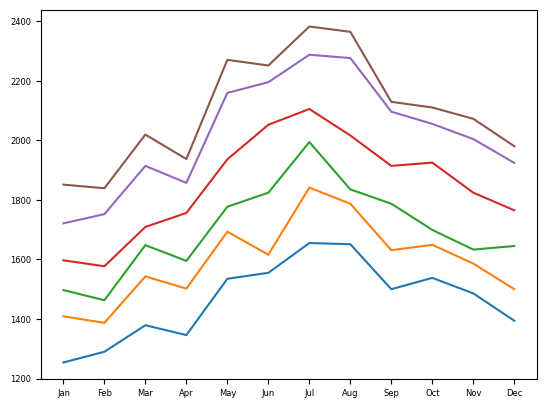

In [99]:
# Import data
series_b1 = pd.read_excel('/content/timeseries/datasets/zemkoho/Electricity.xls', sheet_name ='SeasData', header = 0, index_col =0, parse_dates = True)

# Plot data
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
months = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(x, months)
plt.plot(x, series_b1)
plt.show()

**Interpretação:**

*  Claramente é possível observar uma sazonalidade nos 2 conjuntos de dados, sendo predominante no segundo conjunto.
*  Desta maneira, em princípio, é possivel realizar uma estimativa inicial para os dados de eletricidade, mas não necessariamente para os dados de tijolos.

C. Decomposição temporal

**1. Série de vendas de tijolos nos Estados Unidos**

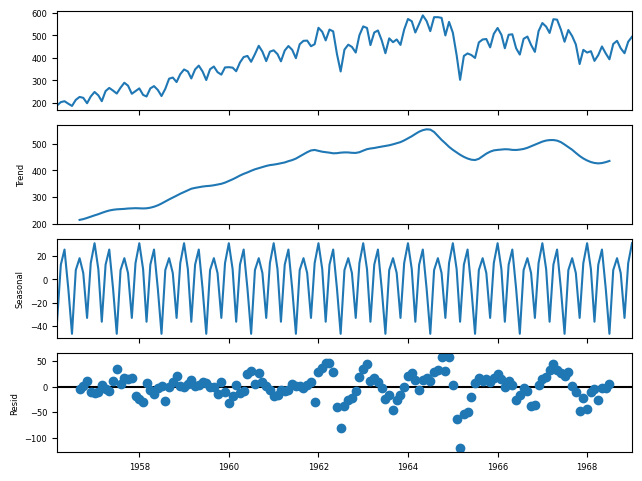

In [100]:
# Additive decomposition
result = seasonal_decompose(series_a, model='additive')

# Plot data
result.plot()
plt.show()

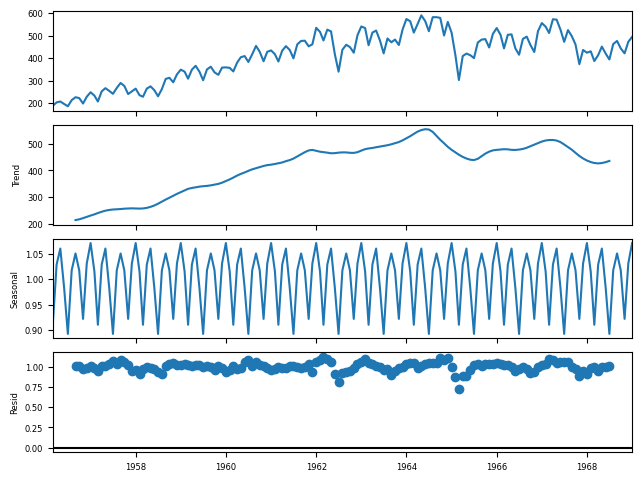

In [101]:
# Multiplicative decomposition
result = seasonal_decompose(series_a, model='multiplicative')

# Plot data
result.plot()
plt.show()

**2. Série da demanda elétrica nos Estados Unidos**

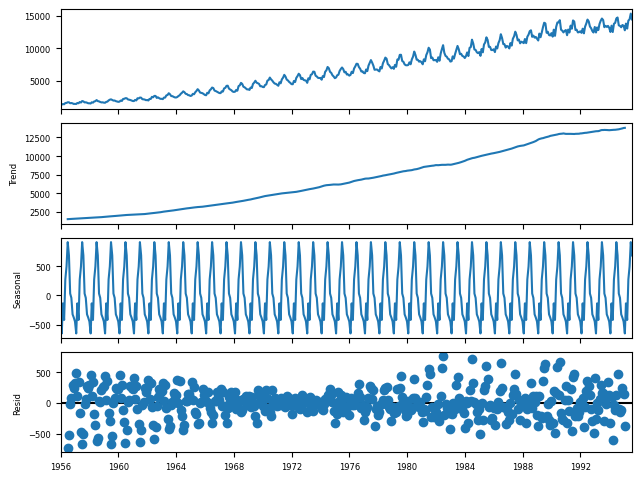

In [102]:
# Additive decomposition
result = seasonal_decompose(series_b, model='additive')

# Plot data
result.plot()
plt.show()

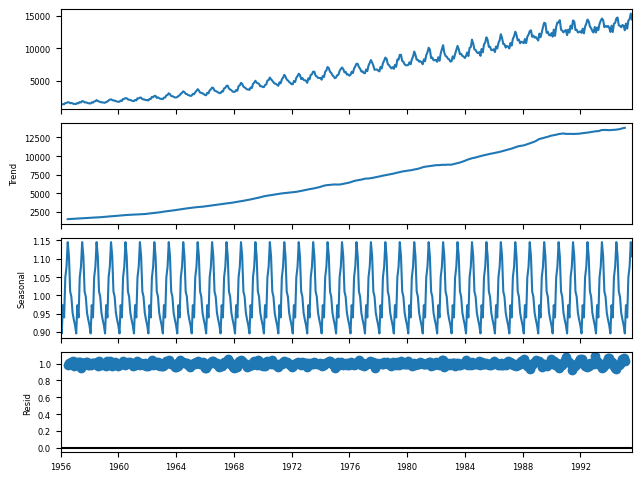

In [103]:
# Multiplicative decomposition
result = seasonal_decompose(series_b, model='multiplicative')

# Plot data
result.plot()
plt.show()

### **3.1.5. Função de Autocorrelação, Estacionariedade e Sazonalidade**

Sabe-se que a autocorrelação é usada para medir o grau de correlação entre diferentes defasagens de tempo em uma série temporal. No entanto, a função de autocorrelação (ACF) é crucial na avaliação de muitas propriedades em estatística, incluindo a sazonalidade, ruído branco e estacionariedade de uma série.

De forma geral, a sazonalidade de uma série se traduz em valores maiores de autocorrelação. Portanto, a sazonalidade deve ser visualizada em gráficos de autocorrelação parcial das séries onde os picos significantes em intervalos regulares durante o ano confirmam a presença da componente sazonal.

**Importante:**

Pode ser válido diferenciar a série temporal, se a mesma for não estacionária, para produzir os gráficos de autocorrelação, possibilitando uma leitura “mais limpa”.

#### Exemplo 03. Séries de vendas de materiais de construção na Australia
---

<ipython-input-104-a897bab38d07>:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-104-a897bab38d07>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



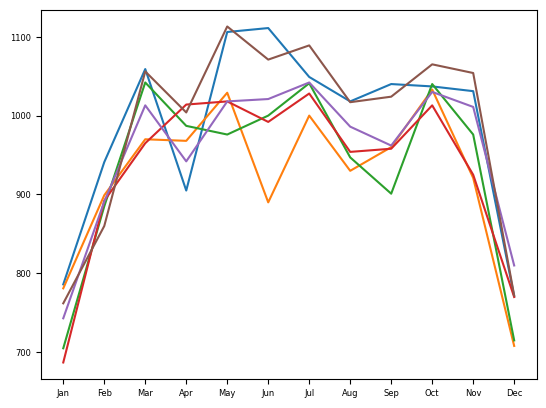

In [104]:
series1 = pd.read_excel('/content/timeseries/datasets/zemkoho/CementProduction.xls', sheet_name='Data', header=0, index_col=0, parse_dates=True)
series2 = pd.read_excel('/content/timeseries/datasets/zemkoho/CementProduction.xls', sheet_name='SeasonalData', header=0, index_col=0, parse_dates=True)

# Plot data
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
months = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(x, months)
plt.plot(x, series2)
plt.show()

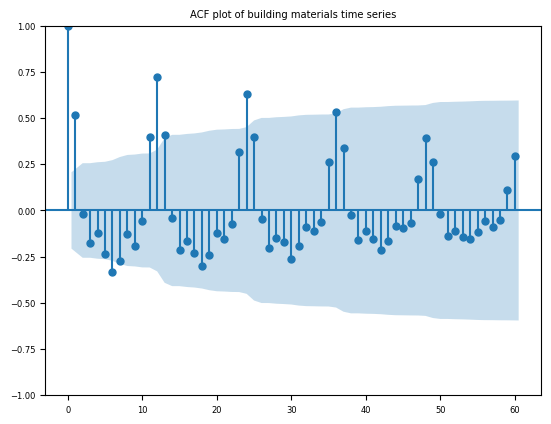

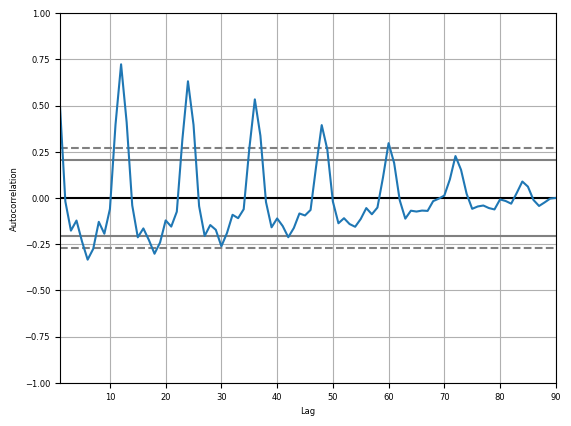

In [105]:
plot_acf(series1, title='ACF plot of building materials time series', lags=60)
plt.show()

autocorrelation_plot(series1)
plt.show()

**Interpretação:**

*  Pode-se ver que os gráficos sazonais podem ser um pouco confusos. Mas o gráfico de autocorrelação (ACF) confirma fortemente a presença de sazonalidade, pois picos e vales estão ocorrendo aproximadamente em intervalos regulares, ou seja, a cada 12 defasagens de tempo, pois os dados são feitos de observações mensais.
*  O segundo gráfico é outra forma de representar a função de autocorrelação em forma de curva, sendo muitas vezes mais explicativo e determinante.

### **3.1.6. Valores atípicos e/ou discrepantes**

As mudanças no nível de uma série temporal que não puderem ser explicadas são referidas como valores discrepantes. Estas observações são inconsistentes com o restante da série e podem influenciar significativamente a análise e, consequentemente, afetar a capacidade de previsão do modelo de série temporal.

Quando os valores discrepantes, ou também chamados de **"outliers"** afetam somente o nível médio da série, eles são  classificados como *deterministas*. Alguns tipos de outliers deterministas são (IBM.com, 2024):

1. **Outlier Aditivo**. Um valor discrepante aditivo aparece como um valor surpreendentemente grande ou pequeno ocorrendo para uma observação única. Observações subsequentes não são afetadas por um valor discrepante aditivo. Os valores discrepantes aditivos consecutivos normalmente são referidos como correções de valor discrepante aditivo.
2. **Innovational Outlier**. Um valor discrepante inovador é caracterizado por um impacto inicial com efeitos que aguardam observações subsequentes. A influência dos valores discrepantes pode aumentar com o decorrer do tempo.
3. **Valor Discrepante de Mudança de Nível**. Para uma mudança de nível, todas as observações que aparecerem após o valor discrepante se movem para um novo nível. Em contraste com valores discrepantes aditivos, um valor discrepante de mudança de nível afeta muitas observações e tem um efeito permanente.
4. **Valor Discrepante de Mudança Temporária**. Os valores discrepantes de mudança temporária são semelhantes aos valores discrepantes de mudança de nível, mas o efeito do valor discrepante diminui exponencialmente durante as observações subsequentes. Eventualmente, a série retorna para seu nível normal.
5. **Valor Discrepante Aditivo Sazonal**. Um valor discrepante aditivo sazonal aparece como um valor surpreendentemente grande ou pequeno ocorrendo repetidamente em intervalos regulares.
6. **Valor Discrepante de Tendência Local**. Um valor discrepante de tendência local produz um desvio geral na série causado por um padrão nos valores discrepantes após o início do valor discrepante inicial.

De forma geral, a detecção de valores discrepantes em séries temporais envolve determinar o local, o tipo e a magnitude de ditos valores.

### **3.1.7. Identificação de outliers. A regra do $3\sigma $**

Um dos métodos mais usados para deteção e eliminação de **outliers** baseia-se na chamada regra do $3\sigma $. Essa abordagem depende do conceito estatístico de desvio padrão, que mede o quanto os pontos de dados se desviam do valor médio.

Três limites de $\sigma$ (sigma) são definidos como o intervalo de valores que deve conter 99,7% dos pontos de dados se os dados forem normalmente distribuídos. Qualquer valor fora desse intervalo é considerado um outlier.

Para entender melhor a regra do $3\sigma $, alguns pontos chave devem ser considerados:

1. A regra baseia-se na suposição de distribuição normal. Isso significa que os pontos de dados devem seguir uma curva em forma de sino, com a maioria dos valores agrupados em torno do valor médio e menos valores à medida que nos afastamos da média. Se os dados não seguirem uma distribuição normal.

2. A regra pode ser usada para detectar outliers positivos e negativos. Um outlier positivo é um valor maior que o limite superior de três limites de $\sigma$, enquanto um outlier negativo é um valor menor que o limite inferior dos três limites de $\sigma$.

4. A regra pode ser ajustada para ser mais ou menos rigorosa, dependendo do nível de sensibilidade necessário. Por exemplo, se queremos ser mais conservadores na detecção, podemos usar $2\sigma $, o que conterá 95% dos pontos de dados.

#### Exemplo 04. Série de coordenadas. Deteção de outliers pela regra do $3\sigma $
---

A. Amostragem do conjunto de dados

In [106]:
# Definir coluna "Date" como indexador da Tabela
df_gps_t = df_gps.set_index('Decimal Year')

# Definir o intervalo de tempo para amostragem
df_gps_range = df_gps_t.loc['2008':'2024']

df_gps_range.head()

,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU
Decimal Year,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889
2008.0110,UFPR,08JAN05,54470,1460,6,-49.2,-3113.39712,-2.815723e+06,925.77837,0.1,0.00074,0.00076,0.00313,0.07715,-0.01121,0.07901


B. Histograma do conjunto de dados amostrados

<ipython-input-107-ee41c8e9e18e>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




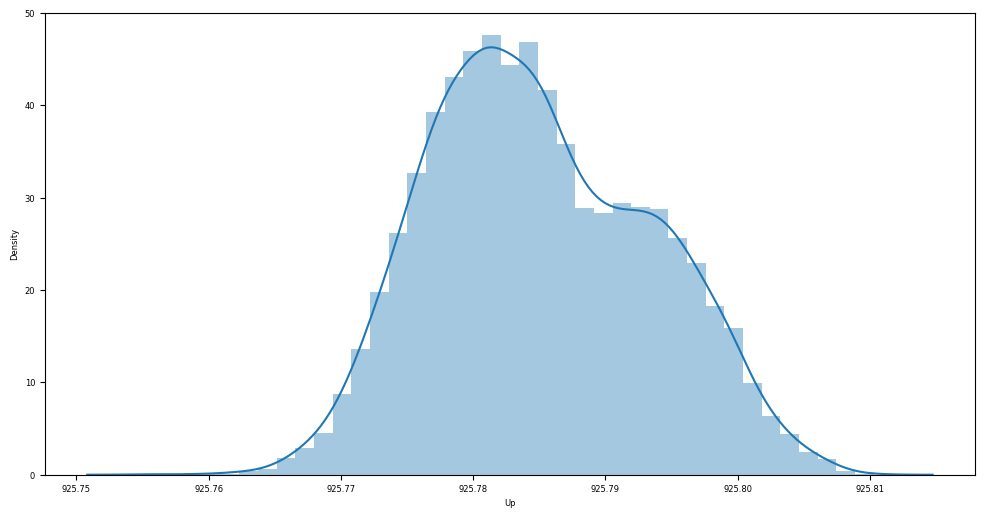

In [107]:
plt.figure(figsize=(12,6))
sns.distplot(df_gps_range['Up'])
plt.show()

C. Determinação dos límites $3\sigma$

In [108]:
# Finding the bounadray values
Height_limit = df_gps_range["Up"].mean()+3*df_gps_range["Up"].std()
Lowest_limit = df_gps_range["Up"].mean()-3*df_gps_range["Up"].std()

# Identify anomalies
anomalies = df_gps_range[(df_gps_range["Up"] >  Height_limit )|(df_gps_range["Up"] < Lowest_limit)]

E. Apresentação dos resultados

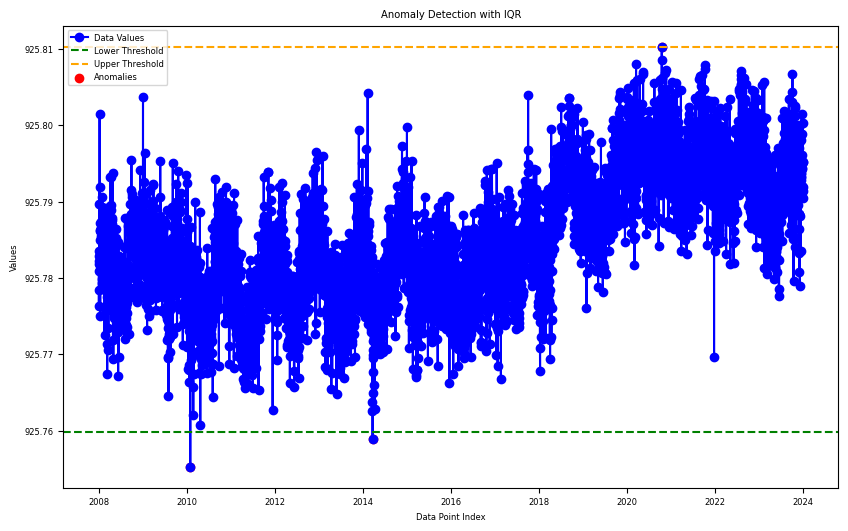

Anomalies:
             Station     Date    MJD  GPS Week  Week Day  Longitude  \
Decimal Year                                                          
2010.0808       UFPR  10JAN30  55226      1568         6      -49.2   
2014.2204       UFPR  14MAR22  56738      1784         6      -49.2   
2020.7858       UFPR  20OCT14  59136      2127         3      -49.2   

                    East         North         Up  Antenna Height       dE  \
Decimal Year                                                                 
2010.0808    -3113.40615 -2.815723e+06  925.75528             0.1  0.00073   
2014.2204    -3113.42295 -2.815723e+06  925.75892             0.1  0.00072   
2020.7858    -3113.44464 -2.815722e+06  925.81028             0.1  0.00075   

                   dN       dU   corrEN   corrEU   corrNU  
Decimal Year                                               
2010.0808     0.00076  0.00321  0.03406 -0.04085  0.12578  
2014.2204     0.00077  0.00320  0.01274  0.00911  0.02711  
20

In [109]:
# Plot the values
plt.figure(figsize=(10, 6))
plt.plot(df_gps_range['Up'], label='Data Values', marker='o', linestyle='-', color='blue')

# Plot the thresholds
plt.axhline(y=Lowest_limit, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(y=Height_limit, color='orange', linestyle='--', label='Upper Threshold')

# Highlight anomalies on the graph
plt.scatter(anomalies.index, anomalies['Up'], color='red', label='Anomalies')

# Set labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Anomaly Detection with IQR')
plt.legend()

# Show the plot
plt.show()

# Print the anomalies
print("Anomalies:")
print(anomalies)

### **3.1.8. Identificação de outliers. Rango Interquartil**

A identificação de outliers (i.e., valores atípicos, distantes dos demais pontos da série) pode ser feita utilizando o chamado de amplitude ou rango interquartil (IQR). Neste caso, entende-se como um outlier, valores menores que $Q_1 - 1,5  \times  IQR$ ou valores maiores que $Q_3 + 1,5  \times IQR$.

Estes valores também são representados no boxplot, mas como pontos acima ou abaixo da linha conectada à caixa. Isto é:

<center><img src=https://estatsite.com.br/wp-content/uploads/2018/12/50-768x498.png width="400"></center>

  <center>Figura 04. Boxplot e Amplitude Interquartil</center>

  <center>Fonte: estatsite.com.br (2018)</center>

#### Exemplo 05. Série de coordenadas. Deteção de outliers pela método IQR
---

A. Cálculo dos Intervalos IQR

In [110]:
# Calculate Quartiles and IQR
Q1 = df_gps_range['Up'].quantile(0.25)
Q3 = df_gps_range['Up'].quantile(0.75)
IQR = Q3 - Q1

# Set a threshold for anomaly detection (e.g., 1.5 times IQR)
threshold_lower = Q1 - 1.5 * IQR
threshold_upper = Q3 + 1.5 * IQR

# Identify anomalies
anomalies = df_gps_range[(df_gps_range['Up'] < threshold_lower) | (df_gps_range['Up'] > threshold_upper)]

B. Apresentação dos resultados

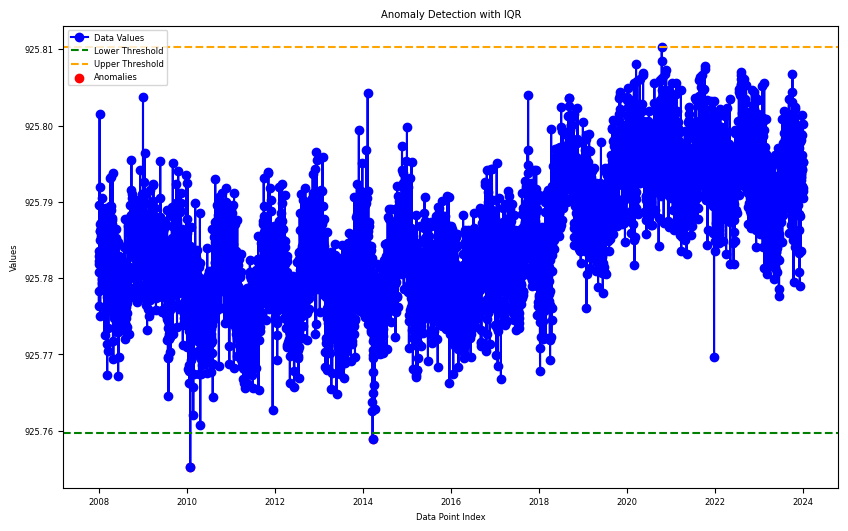

Anomalies:
             Station     Date    MJD  GPS Week  Week Day  Longitude  \
Decimal Year                                                          
2010.0808       UFPR  10JAN30  55226      1568         6      -49.2   
2014.2204       UFPR  14MAR22  56738      1784         6      -49.2   

                    East         North         Up  Antenna Height       dE  \
Decimal Year                                                                 
2010.0808    -3113.40615 -2.815723e+06  925.75528             0.1  0.00073   
2014.2204    -3113.42295 -2.815723e+06  925.75892             0.1  0.00072   

                   dN       dU   corrEN   corrEU   corrNU  
Decimal Year                                               
2010.0808     0.00076  0.00321  0.03406 -0.04085  0.12578  
2014.2204     0.00077  0.00320  0.01274  0.00911  0.02711  


In [111]:
# Plot the values
plt.figure(figsize=(10, 6))
plt.plot(df_gps_range['Up'], label='Data Values', marker='o', linestyle='-', color='blue')

# Plot the thresholds
plt.axhline(y=threshold_lower, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(y=threshold_upper, color='orange', linestyle='--', label='Upper Threshold')

# Highlight anomalies on the graph
plt.scatter(anomalies.index, anomalies['Up'], color='red', label='Anomalies')

# Set labels and title
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Anomaly Detection with IQR')
plt.legend()

# Show the plot
plt.show()

# Print the anomalies
print("Anomalies:")
print(anomalies)

### **3.1.9. Homocedasticidade e Heterocedasticidade**

De forma geral, o modelo de Gauss-Markov estabelece que para descrever uma série através de um modelo matemático geral (i.e. previsão por mínimos quadrados), é necessário que dita série cumpra alguns requisitos tanto dos **processos de Gauss**, como dos **processos de Markov** (Processo Ornstein–Uhlenbeck):.

<center><img src=https://iili.io/dVHdi2n.md.png width="500"></center>

De forma particular, quando falamos do comportamento da variância, se diz que:

1. A variabilidade dos erros $e$, condicionada aos valores das variáveis explanatórias é constante, ou seja, os erros são homocedásticos, se sua variância é constante ao longo do tempo.

$$ Var\left ( e_{i}|X_{1},X_{2},\cdots ,X_{k_{i}} \right )=\sigma ^{2}$$

2. A variabilidade dos erros $e$, condicionada aos valores das variáveis explanatórias é varíavel, ou seja, os erros são heterocedásticos, se sua variância é diferente para cada valor  condicional de $X_{j_{i}}$.

$$Var\left ( e_{i}|X_{1},X_{2},\cdots ,X_{k_{i}} \right )=\sigma_{i} ^{2}$$

Graficamente isto pode ser representado como:

<center><img src=https://iili.io/dSmTZE7.md.png width="600"></center>









### **3.1.10. Teste de Breusch-Pagan**

Em estatística, o teste de Breusch-Pagan é utilizado para determinar a heterocedasticidade em um modelo de regressão linear. Analisa se a variância estimada dos resíduos de uma regressão depende dos valores das variáveis ​​independentes.

Este teste usa duas suposições hipotéticas:

* $H_0$ (Hipótese Nula):

 A homocedasticidade está presente (os resíduos são distribuídos com variância igual).

* $H_A$ (Hipótese Alternativa):

 A heterocedasticidade está presente (os resíduos não são distribuídos com variância igual)

Se o *valor p* dos resultados do teste for menor que $\alpha$ (nível de significância), podemos rejeitar $H_0$ e concluir que os dados são heterocedásticos (geralmente é utilizado 0,05 como nível de significância).

#### Exemplo 06. Série de coordenadas. Teste de Breusch-Pagan
---
A. Amostragem do conjunto de dados

In [112]:
# Definir coluna "Date" como indexador da Tabela
df_gps_t = df_gps.set_index('Decimal Year')

# Definir o intervalo de tempo para amostragem
df_gps_range = df_gps_t.loc['2008':'2024']

df_gps_range.head()

,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU
Decimal Year,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889
2008.0110,UFPR,08JAN05,54470,1460,6,-49.2,-3113.39712,-2.815723e+06,925.77837,0.1,0.00074,0.00076,0.00313,0.07715,-0.01121,0.07901


B. Cálculo do modelo de regressão linear

In [113]:
df_model = ols(formula='North~MJD', data=df_gps_range).fit()

C. Geração de uma função para transformar os dados de Dataframe a Numpy

In [114]:
def test_model(col):
  s = []
  for i in col:
    a = [1,i]
    s.append(a)
  return (np.array(s))

C. Cálculo do Teste de Breusch-Pagan

In [115]:
comp_model = test_model(df_gps_range['North'])

bp_test = het_breuschpagan(df_model.resid, comp_model)

print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
1.3908916104610337e-35


**Interpretação:**

O resultado do *valor p* do teste está muito abaixo do nível de significância, portanto podemos rejeitar a $H_0$ (i.e. os dados são heterocedásticos).

## **3.2. Transformações**

De acordo com Morettin, P. & Toloi, C. (2014), há, basicamente, duas razões para transformar os dados originais de uma série temporal:

1.   Estabilizar a variância dos dados.
2.   Tornar o efeito sazonal aditivo.
3.   Obter uma distribuição para os dados mais simétrica e próxima da normal.

Um exemplo de séries que precisam ser transformadas antes de poder ser analisadas estatísticamente, são aquelas séries com tendências e/ou variâncias crescentes á medida que o tempo passa. Neste caso, por exemplo, o uso de uma transformação logarítimica pode ser adequada.

**Importante:**

No entanto, as transformações de séries possuim algumas restrições a ser consideradas. Neste sentido, é importante citar algumas pesquisas com relação a este tema:

*   Nelson (1976) conclui que as transformações não melhoram a qualidade da previsão.
*   Granger e Newbold (1976) mostram que as previsões dos antilogaritmos dos dados transformados são estimadores viesados, pelo qual, deveriam serem ajustados (i.e. após a transformação, um víes é introduzido nas previsões).
*   Granger e Newbold (1976) também observam que a heteroscedasticidade não afeta a adequação da previsão, pois ela não implica em estimadores viesados, como no caso da regressã múltipla.
*   Plosser (1979) observa que quando se tem um conjunto de dados que apresenta um padrão sazonal, é muito comum fazer um ajustamento sazonal dos dados e depois usar um modelo não-sazonal para se fazer a previsão. Não entanto, pode ser preferível fazer a previsão usando diretamente o modelo sazonal ao invés de ajustar sazonalmente a série.

### **3.2.2. Cómo saber escolher a transformação?**

Para ter uma idéia do tipo de transformação que é adequada, pode-se utilizar um gráfico que traz no eixo das abcissas **médias de subconjuntos de observações da série original** e no eixo das ordenadas a **amplitude de cada um desses subconjuntos**.

Desta forma, se $Z_{1},\cdots ,Z_{k}$ for um subconjunto de $Z_t$ com $k$ observações, calculamos:

$$\overline{Z}=\frac{1}{k}\sum_{i=1}^{k}Z_{t_{i}}$$

e

$$w=max\left ( Z_{t_{i}} \right )-min\left ( Z_{t_{i}} \right )$$

que são medidas de posição e variabiliade respectivamente. O par $\left ( \overline{Z},w \right )$ será um **ponto** do gráfico.

**Importante:**

O número de elementos em cada sub-série pode ser igual ao período, no caso de séries sazonais.

**Interpretação:**

<center><img src=https://iili.io/dsODTyQ.md.jpg width="400"></center>

<center>Figura 1. Gráfico amplitude x média com valores de $\lambda$</center>

<center>Fonte: Jenkins (1979)</center>


* Se $w$ independer de $\overline{Z}$, obteremos pontos espalhados ao redor de uma reta paralela ao eixo das abcissas. Neste caso não haverá necessidade de transformação.
* Se $w$ for diretamente proporcional a $\overline{Z}$, a transformação logarítmica é apropriada.
* Nos outros casos, diversas curvas serão geradas, sendo necessário implementar outro tipo de transformações mais elaboradas.

No caso de querer obter uma distribuição mais simétrica e próxima da normal, Hinkley (1977) sugere que se calcule a média, mediana e um estimador de escala robusto (i.e. desvio padrão) e, então, para a transformação $Z_{t}^{\left ( \lambda  \right )}$, com valores para $\lambda$ de: ..., -3, -2, -1, -1/2, -1/4, 0, 1/4, 1/2, 1, 2, 3, ..., escolha-se o valor de $\lambda$ que minimize a relação:

$$d_{\lambda }=\frac{\left|media- mediana \right|}{estimador}$$

que pode ser vista como uma medida de assimetria (i.e. numa distribuição simétrica, $d_{\lambda }=0$).

#### Exemplo 07. Série de coordenadas. Análise das médidas de posição e estabilidade
---
A. Importar o conjunto de dados

In [116]:
# Definir nomes de cada coluna
header = ['Station','Date','Decimal Year','MJD','GPS Week','Week Day','Longitude','East','North','Up','Antenna Height','dE','dN','dU','corrEN','corrEU','corrNU']

# Importar arquivo de texto (dataframe Pandas)
df_gps = pd.read_csv("/content/timeseries/datasets/ngl/UFPR.tenv", names=header, delim_whitespace=True)

# Apresentar tabela de dados
df_gps.head()

,Station,Date,Decimal Year,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU
0,UFPR,96DEC14,1996.9528,50431,883,6,-49.2,-3113.36397,-2.815723e+06,925.75507,0.155,0.00098,0.00096,0.00441,0.03008,0.00245,0.07710
1,UFPR,96DEC15,1996.9555,50432,884,0,-49.2,-3113.36524,-2.815723e+06,925.75194,0.155,0.00097,0.00099,0.00439,0.00931,0.04183,0.05181
2,UFPR,96DEC16,1996.9582,50433,884,1,-49.2,-3113.36607,-2.815723e+06,925.74076,0.155,0.00100,0.00098,0.00442,-0.03754,0.00249,0.06097
3,UFPR,96DEC17,1996.9610,50434,884,2,-49.2,-3113.36379,-2.815723e+06,925.74558,0.155,0.00103,0.00105,0.00468,0.02839,0.03994,0.04081
4,UFPR,96DEC18,1996.9637,50435,884,3,-49.2,-3113.36239,-2.815723e+06,925.75661,0.155,0.00100,0.00096,0.00427,-0.03851,0.00671,0.02549


B. Plotar os dados

In [117]:
# Ativar "plotly" para geração de gráficos interativos
pd.options.plotting.backend = "plotly"

# Geração da série de coordenadas
fig = df_gps.plot(title = "UFPR Continuous Monitoring GNSS Station. North Component", x = 'Decimal Year', y = 'North')

# Apresentar série de tempo
fig.show()

C. Amostragem do conjunto de dados

In [118]:
# Criar coluna com a parte inteira do ano decimal
df_gps['Year'] = df_gps['Decimal Year'].apply(lambda x: str(x)[:4])

# Agrupar tabela pela coluna "Year"
grouped = df_gps.groupby(df_gps.Year)

# Criar dataframes por ano
df_gps_2010 = grouped.get_group("2010")
df_gps_2011 = grouped.get_group("2011")
df_gps_2012 = grouped.get_group("2012")
df_gps_2013 = grouped.get_group("2013")
df_gps_2014 = grouped.get_group("2014")
df_gps_2015 = grouped.get_group("2015")
df_gps_2016 = grouped.get_group("2016")
df_gps_2017 = grouped.get_group("2017")
df_gps_2018 = grouped.get_group("2018")
df_gps_2019 = grouped.get_group("2019")
df_gps_2020 = grouped.get_group("2020")
df_gps_2021 = grouped.get_group("2021")
df_gps_2022 = grouped.get_group("2022")
df_gps_2023 = grouped.get_group("2023")

D. Cálculo das medidas de posição e variabilidade

In [119]:
# Cálculo da média
z_2010 = df_gps_2010['North'].mean()
z_2011 = df_gps_2011['North'].mean()
z_2012 = df_gps_2012['North'].mean()
z_2013 = df_gps_2013['North'].mean()
z_2014 = df_gps_2014['North'].mean()
z_2015 = df_gps_2015['North'].mean()
z_2016 = df_gps_2016['North'].mean()
z_2017 = df_gps_2017['North'].mean()
z_2018 = df_gps_2018['North'].mean()
z_2019 = df_gps_2019['North'].mean()
z_2020 = df_gps_2020['North'].mean()
z_2021 = df_gps_2021['North'].mean()
z_2022 = df_gps_2022['North'].mean()
z_2023 = df_gps_2023['North'].mean()

z_values = [z_2010, z_2011, z_2012, z_2013, z_2014, z_2015, z_2016, z_2017, z_2018, z_2019, z_2020, z_2021, z_2022, z_2023]

# Cálculo da medida de variabilidade
w_2010 = df_gps_2010['North'].max() - df_gps_2010['North'].min()
w_2011 = df_gps_2011['North'].max() - df_gps_2011['North'].min()
w_2012 = df_gps_2012['North'].max() - df_gps_2012['North'].min()
w_2013 = df_gps_2013['North'].max() - df_gps_2013['North'].min()
w_2014 = df_gps_2014['North'].max() - df_gps_2014['North'].min()
w_2015 = df_gps_2015['North'].max() - df_gps_2015['North'].min()
w_2016 = df_gps_2016['North'].max() - df_gps_2016['North'].min()
w_2017 = df_gps_2017['North'].max() - df_gps_2017['North'].min()
w_2018 = df_gps_2018['North'].max() - df_gps_2018['North'].min()
w_2019 = df_gps_2019['North'].max() - df_gps_2019['North'].min()
w_2020 = df_gps_2020['North'].max() - df_gps_2020['North'].min()
w_2021 = df_gps_2021['North'].max() - df_gps_2021['North'].min()
w_2022 = df_gps_2022['North'].max() - df_gps_2022['North'].min()
w_2023 = df_gps_2023['North'].max() - df_gps_2023['North'].min()

w_values = [w_2010, w_2011, w_2012, w_2013, w_2014, w_2015, w_2016, w_2017, w_2018, w_2019, w_2020, w_2021, w_2022, w_2023]

E. Plotagem das medidas de posição e variabilidade

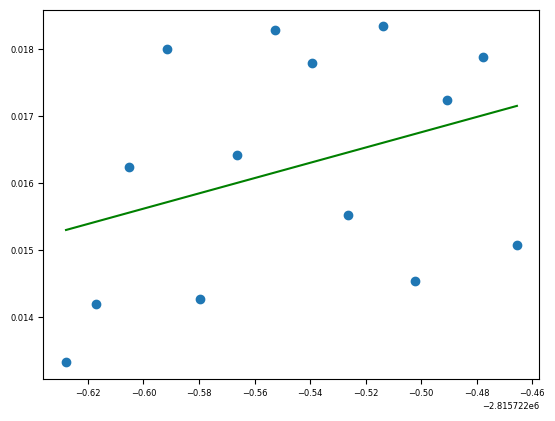

In [120]:
# Criação de um modelo de ajuste polinomial
model1 = np.poly1d(np.polyfit(z_values, w_values, 1))
polyline = np.linspace(min(z_values), max(z_values), 100)

# Geração do grafico
plt.scatter(z_values, w_values)
plt.plot(polyline, model1(polyline), color='green')

#### Exemplo 08. Série de coordenadas. Eliminação da heteroscedasticidade
---
A. Amostragem do conjunto de dados

In [121]:
# Definir coluna "Date" como indexador da Tabela
df_gps_t = df_gps.set_index('Decimal Year')

# Definir o intervalo de tempo para amostragem
df_gps_range = df_gps_t.loc['2008':'2024']

df_gps_range.head()

,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU,Year
Decimal Year,,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435,2008
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799,2008
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430,2008
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889,2008
2008.0110,UFPR,08JAN05,54470,1460,6,-49.2,-3113.39712,-2.815723e+06,925.77837,0.1,0.00074,0.00076,0.00313,0.07715,-0.01121,0.07901,2008


B. Cálculo do modelo de regressão linear

In [122]:
df_model = ols(formula='North~MJD', data=df_gps_range).fit()

C. Geração de uma função para transformar os dados de Dataframe a Numpy

In [123]:
def test_model(col):
  s = []
  for i in col:
    a = [1,i]
    s.append(a)
  return (np.array(s))

C. Cálculo do Teste de Breusch-Pagan (Determinar se a série é ou não estacionária)

In [124]:
comp_model = test_model(df_gps_range['North'])

bp_test = het_breuschpagan(df_model.resid, comp_model)

print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
1.3908916104610337e-35


**Interpretação:**

O resultado do *valor p* do teste está muito abaixo do nível de significância, portanto podemos rejeitar a $H_0$ (i.e. os dados são heterocedásticos).

D. Transformação logarítmica

In [125]:
df_gps_range['log_North'] = np.log(df_gps_range['North'])

df_gps_range.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

<ipython-input-125-65334f6a325c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU,Year,log_North
Decimal Year,,,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435,2008,NaN
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799,2008,NaN
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430,2008,NaN
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889,2008,NaN
2008.0110,UFPR,08JAN05,54470,1460,6,-49.2,-3113.39712,-2.815723e+06,925.77837,0.1,0.00074,0.00076,0.00313,0.07715,-0.01121,0.07901,2008,NaN


D.1. Normalização da série (a valores positivos)

In [126]:
df_gps_range['norm_North'] = df_gps_range['North'] - (df_gps_range['North'].min() + 0.0001)

df_gps_range['log_North'] = np.log(df_gps_range['norm_North'])

df_gps_range.dropna(inplace=True)

df_gps_range.head()

<ipython-input-126-d0525ef86f89>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

<ipython-input-126-d0525ef86f89>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-126-d0525ef86f89>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU,Year,log_North,norm_North
Decimal Year,,,,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435,2008,-6.692644,0.00124
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799,2008,-6.515713,0.00148
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430,2008,-5.516473,0.00402
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889,2008,-5.918214,0.00269
2008.0137,UFPR,08JAN06,54471,1461,0,-49.2,-3113.39586,-2.815723e+06,925.78962,0.1,0.00074,0.00077,0.00316,0.07757,0.02085,0.09110,2008,-5.944581,0.00262


D.2. Plotagem da série normalizada

In [127]:
# Ativar "plotly" para geração de gráficos interativos
pd.options.plotting.backend = "plotly"

# Geração da série de coordenadas
fig = df_gps_range.plot(title = "UFPR Continuous Monitoring GNSS Station. North Component", x = 'MJD', y = 'norm_North')

# Apresentar série de tempo
fig.show()

D.3. Cálculo do Teste de Breusch-Pagan

In [128]:
df_model = ols(formula='log_North~MJD', data=df_gps_range).fit()

log_model = test_model(df_gps_range['log_North'])

bp_test = het_breuschpagan(df_model.resid, log_model)

print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
0.0


**Interpretação:**

O resultado do *valor p* do teste é zero, próximo do nível de significância, portanto não existe um critério marcado para poder aceitar ou rejeitar a $H_0$.

E. Transformação de Box-Cox

E.1. Cálculo do modelo de Box-Cox

In [129]:
x, _ = stats.boxcox(df_gps_range['norm_North'])

df_gps_range['trans_North'] = x

<ipython-input-129-ea15dd5c4f9c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



E.2. Cálculo do Teste de Bresuch-Pagan

In [130]:
df_model = ols(formula='trans_North~MJD', data=df_gps_range).fit()

trans_model = test_model(df_gps_range['trans_North'])

bp_test = het_breuschpagan(df_model.resid, trans_model)
print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
1.6542021799661598e-81


**Interpretação:**

O resultado do *valor p* do teste está muito abaixo do nível de significância, portanto podemos rejeitar a $H_0$ (i.e. os dados são heterocedásticos).

F. Plotagem das séries transformadas

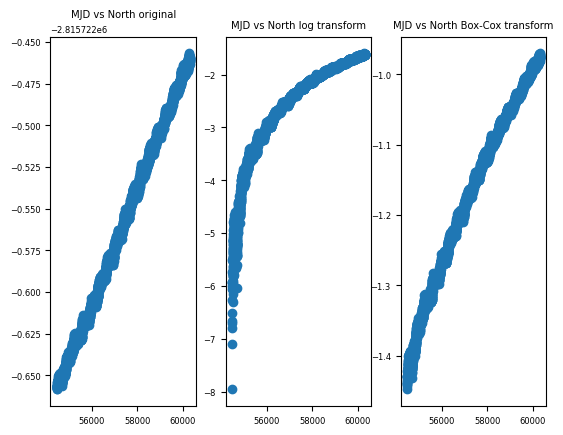

In [131]:
plt.figure()
plt.rcParams.update({'font.size': 6})

plt.subplot(1,3,1)
plt.title('MJD vs North original')
plt.scatter(df_gps_range.MJD, df_gps_range.North)

plt.subplot(1,3,2)
plt.title('MJD vs North log transform')
plt.scatter(df_gps_range.MJD, df_gps_range.log_North)

plt.subplot(1,3,3)
plt.title('MJD vs North Box-Cox transform')
plt.scatter(df_gps_range.MJD, df_gps_range.trans_North)
plt.show()

## **3.3. Estimadores**

Os modelos utilizados para descrever séries temporais são processos estocásticos, isto é, processos controlados por leis probabilísticas.

A construção destes modelos depende de vários fatores, tais como o comportamento do fenômeno ou o conhecimento a priori que temos de sua natureza e do objetivo da análise.

### **3.3.1. Processos estocásticos**

Seja $T$ um conjunto arbitrário de dados. Um *processo estocástico* é uma família $Z=\left\{Z\left ( t \right ),t\cdot \epsilon \cdot T \right\}$, tal que, para cada $t\cdot \epsilon \cdot T$, $Z\left ( t \right )$ é uma variável aleatória.

Nestas condições, um processo estocástico é uma familia de variáveis aleatórias que supomos definidas num mesmo espaço de probabilidades.

<center><img src=https://iili.io/dsv8Vpe.md.jpg width="500"></center>

<center>Fonte: Morettin, P. & Toloi, C. (2014)</center>



### **3.3.2. Especificação de um processo estocástico**

Sejam $t_1$, $t_2$, ...$t_n$ elementos quaisquer de T e consideremos:

$$F(z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n})=P\left ( Z\left ( t_{1} \right )\leq z_{1},\cdots ,Z\left ( t_{n} \right )\leq z_{n} \right )$$

Então, o processo estocástico $Z=\left\{Z\left ( t \right ),t\cdot \epsilon \cdot T \right\}$ estará especificado se conhecermos as *distribuições finito-dimensionais* para todo $n\geq 1$.

Na prática, não conhecemos todas essas distribuições finito-dimensionais, pelo qual, estuda-se certas características associadas à função $F(z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n})$ que sejam simples de calcular e interpretar.

Uma maneira comumente utilizada para estudar o processo $Z$ é determinar todos os momentos produtos de ordem $\left ( r_{1},\cdots ,r_{n} \right )$ das variáveis aleatórias $Z\left ( t_{1} \right ),\cdots ,Z\left ( t_{n} \right )$. Ou seja, determinar:

$$\mu \left ( r_{1},\cdots ,r_{n};t_{1},\cdots ,t_{n} \right )=E\left\{ Z^{r_{1}\left ( t_{1} \right )}\cdots Z^{r_{n}\left ( t_{n} \right )} \right\}=\int_{-\infty }^{\infty }\int_{-\infty }^{\infty }z_{1}^{r_{1}}\cdots z_{n}^{r_{n}}f\left ( z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n} \right )d_{z_{1}}\cdots d_{z_{n}}$$

onde $f\left ( z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n} \right )$ é a função de probabilidade correspondente a $F(z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n})$.

Em particular, o que se faz, é restringir o estudo a momentos de baixa ordem, sendo os mais importantes a média:

$$\mu \left ( t \right )=E\left\{Z\left ( t \right ) \right\}$$

e a função de autocovariância:

$$\gamma \left ( t_{1},t_{2} \right )=cov\left\{Z\left ( t_{1} \right ),Z\left ( t_{2} \right ) \right\}$$

**Importante:**

Naquelas situações em que se pretende utilizar modelos para descrever séries temporais, é necessário introduzir suposições simplificadoras, que nos conduza a analisar determinadas classes de processos estocásticos. Entre algumas alternativas temos:

1.   Processos estacionários ou não-estacionários, de acordo com a independência ou não relativamenteà origem dos tempos;
2.   Processos normais (Gaussianos) ou não-normais, de acoro com as funções de probabilidade que caracterizam os processos;
3.   Processos Markovianos ou não-Markovianos, de acordo com a independência dos valores do processo, em dado instante, de seus valores em instantes precedentes.

### **3.3.3. Tipo de estimadores/modelos**

De forma geral, podemos classificar os modelos para séries temporais segundo o número de parâmetros envolvidos da forma:

1. **Modelos paramêtricos** para os quais este número de parâmetros é finito.

 Na clase de modelos e/ou estimadores paramêtricos, a análise e feita no dominio do tempo. Dentre estes modelos os mais usados são: os modelos de erro (ou de regressão), os modelos de suavização exponencial, os modelos auto-regressivos e de médias móveis (ARMA), os modelos auto-regressivos integrados e de médias móveis (ARIMA), modelos de memória longa (ARFIMA), modelos estruturais e modelos não-lineares.

2. **Modelos não-paramêtricos** que envolvem um número infinito de parâmetros.

 Os modelos e/ou estimadores não-paramêtricos mais utilizados são a função de autocovariância (ou autocorrelação) e sua transformada de Fourier, o espectro (i.e. do ponto de vista matemático, estas funções são pares de Fourier e portanto equivalentes).

 A vantagem de se descrever a série no domínio de frequências está no fato de se eliminar o problema de correlação serial, pois na análise espectral os componentes são ortogonais.

### **3.3.4. Modelos de erro ou de regressão**

**3.3.4.1. Modelo de regressão não-paramétrica**

De forma geral, seja:

$$Z_{t}=f\left ( t \right )+a_{t} \rightarrow t=1,\cdots ,N$$

uma série temporal, onde $f\left ( t \right )$ é chamada de *sinal* e $a_{t}$ de ruído.

Se assumirmos que $f\left ( t \right )$ pertence a uma classe particular de funções e quisermos estimar essa função, para todo $t$, teremos um modelo "semi-paramétrico", pois além de $f$, teremos que estimar a variância do ruído $\left\{a_{t} \right\}$. Normalmente, esse problema é denominado de *regressão  não-paramétrica*.

**3.3.4.2. Modelo de regressão paramétrica**

Se no modelo o sinal $f\left ( t \right )$ é uma função do tempo completamente determinada (parte sistemática ou determinística) e $a_t$ é uma sequência aleatória de variáveis não-correlacionadas, independente de $f\left ( t \right )$, com média zero e variância constante. Isto é:

$$\begin{matrix}
E\left ( a_{t} \right )=0, \forall t, & E\left ( a_{t}^{2} \right )=\sigma _{a}^{2}, \forall t, & E\left ( a_{t} a_{s}\right )=0, s\neq t  \\
\end{matrix}$$

o modelo chama-se de *modelo de erro ou de regressão*.

Neste caso:

* Qualquer efeito do tempo influencia somente a parte deterministica $f\left ( t \right )$.
* a série $a_t$ é considerada de *ruido branco* (i.e. observações não-correlacionadas).

**3.3.4.3. Derivações do modelo de regressão**

1.   **Modelo de média constante**

 $$\begin{matrix}
Z_{t}=Q+a_{t} & t=1,\cdots ,N, \\
\end{matrix}$$

 onde $f\left ( t \right )=Q$ é uma constante.

2.   **Modelo de tendência linear**

 $$\begin{matrix}
Z_{t}=\alpha +\beta t+a_{t} & t=1,\cdots ,N, \\
\end{matrix}$$

 onde $f\left ( t \right )=\alpha +\beta t$ é uma função linear dos parâmetros.

3.   **Modelo de regressão**

 $$\begin{matrix}
Z_{t}=\alpha +\beta x_{t}+a_{t} & t=1,\cdots ,N, \\
\end{matrix}$$

 onde $f\left ( t \right )=\alpha +\beta x_{t}$ é uma função linear dos parâmetros, sendo $x_{t}$ uma quantidade (fixa) observável.

 **Importante:** Neste casos, onde $f\left ( t \right )$ é uma função linear dos parâmetros, estes podem ser estimados usando-se o método de mínimos quadrados.

4.   **Modelo de curva de crecimento**

 $$\begin{matrix}
Z_{t}=\alpha +e^{\beta t+a_{t}} & t=1,\cdots ,N, \\
\end{matrix}$$

 Neste caso, $f\left ( t \right )$ não é uma função linear dos parâmetros, embora o seu logaritmo $log\left ( Z_{t} \right )$ o seja.

**3.3.4.4 A função $f\left ( t \right )$**

2 tipos importante de funções para $f\left ( t \right )$ são:

1. Polinômio em t, em geral de grau baixo, da forma:

 $$f\left ( t \right )=\beta _{0}+\beta _{1}t+\cdots +\beta _{m}t^{m}$$

 de modo que a componente sistemática se move lenta, suave e progressivamente no tempo; neste caso $f\left ( t \right )$ representa uma *tendência polinomial determinística de grau m* (i.e. o processo $Z_t$ será não-estacionário, se $m>0$).

2. Polinômio harmônico, ou seja, uma combinação linear de senos e cosenos com coeficientes constantes, da forma:

 $$f\left ( t \right )=\sum_{n=1}^{p}\left\{\alpha _{n}cos\lambda _{n}t+\beta _{n}sen\lambda _{n}t \right\}$$

 com $\lambda _{n}=2\pi \frac{n}{p}$ se $f\left ( t \right )$ tiver periódo $p$.

 O modelo de erro é o modelo clássico na análise de séries geodésicas (i.e. modelo de trajetórias estándar), sendo que $f\left ( t \right )$ é composta da *adição* ou *multiplicação* de ambos os tipos de função:

 * o polinômio em t representará a tendência, e
 * o polinômio harmônico as flutuações cíclicas e as variações sazonais.

 Ou seja:

 $$f\left ( t \right )=T_{t}+S_{t}$$

 de modo que:

 $$Z_{t}=T_{t}+S_{t}+a_{t}$$

 Normalmente, $T_t$ é a componente ciclo-tendência incluindo as flutuaões cíclicas de longo periódo, que não podem ser detectadas com os dados disponíveis, enquanto $S_t$ é a componente sazonal ou anual.

#### Exemplo 09. Série de coordenadas. Modelo de regressão linear
---
A. Importar o conjunto de dados

In [132]:
# Data for analysis
X = df_gps_range.loc[:, ['MJD']]  # features
y = df_gps_range.loc[:, 'norm_North']  # target

B. Construir o modelo

In [133]:
# Train the model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

b, m = results.params
print(f"The intercept is {b} and the slope is {m}")

The intercept is -1.8650135206112357 and the slope is 3.423859896326857e-05


C. Resumo do modelo

In [134]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             norm_North   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.116e+06
Date:                Tue, 01 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:18:44   Log-Likelihood:                 26432.
No. Observations:                5773   AIC:                        -5.286e+04
Df Residuals:                    5771   BIC:                        -5.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8650      0.001  -1674.999      0.0

### **3.3.5. Modelos de suavização exponencial**

Referência principal: analisemacro.com.br (2024)

---

Os métodos de suavização exponencial produzem previsões a partir de médias ponderadas de observações passadas, onde o peso associado a cada observação cai a medida em que se recua mais no tempo. Ou seja, quanto mais recente a observação, maior será seu peso no modelo preditivo.

Entre os principais modelos de suavização tem-se:

1. **Suavização simples**

 O método de suavização exponencial simples (SES) é, como o nome sugere, o mais simples dos métodos, sendo aplicável a dados sem tendência ou sazonalidade com padrão claro.

 Para modelar e prever essa série sem características de tendência ou sazonalidade claras, poderíamos utilizar o método do passeio aleatório, onde todas as previsões para o futuro são iguais ao último valor observado da série:

  $$\hat{y}_{T+h|T} = y_{T}$$

 Dessa forma, o método do passeio aleatório assume que a última observação é a única e mais importante para produzir previsões para a série temporal. Todas as outras observações não possuem importância para prever o futuro. Podemos pensar que esse método é uma média ponderada onde todos os pesos são dados apenas para a última observação.

 Outra possibilidade é prever a série temporal com o método da média, onde todas as previsões para o futuro são iguais à média dos dados observados:

  $$\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t$$

 Dessa forma, o método da média assume que todas as observações da série temporal possuem igual importância (pesos) para produzir previsões para o futuro.

 Note que estes métodos são dois extremos e, na verdade, queremos um método que é um meio termo. É razoável pensar que pesos maiores devem ser dados para as observações mais recentes do que para observações do passado distante. Esse é o conceito por trás do método de suavização exponencial simples, onde as previsões são geradas utilizando médias ponderadas, onde os pesos decaem exponencialmente (os menores pesos são associados com as observações mais antigas):

  $$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots$$

 onde:

 $0 \le \alpha \le 1$ é o parâmetro de suavização que controla a taxa em que os pesos decaem até as observações mais antigas.

 O método SES pode ser representado pelas equações:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f1-1.png width="400"></center>

 * A equação de previsão diz que a previsão para o período $t + 1$ é o nível estimado para o período $t$.

 * A equação de suavização (ou nível) define a estimativa do nível a cada período $t$.

 Note que esse processo precisa iniciar em algum momento, portanto um valor ótimo de início $\ell_0$ e um valor de $\alpha$ precisa ser escolhido.

 De forma similar a regressão linear, a escolha dos parâmetros ótimos podem ser feita minimizando a soma dos quadrado dos resíduos.

  $$\sum_{t=1}^T(y_t - \hat{y}_{t|t-1})^2=\sum_{t=1}^Te_t^2$$

2. **Método de tendência linear de Holt**

 Para contemplar séries temporais que apresentam tendência, o método de suavização exponencial de tendência linear de Holt foi desenvolvido.

 Para modelar e prever essa série com característica de tendência clara, podemos utilizar o método tendência linear de Holt. Esse método possui uma equação de previsão e duas equações de suavização (uma para o nível e outra para a tendência):

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f2-1.png width="450"></center>

 onde:

 $\ell_t$ é o nível estimado da série temporal.

 $b_t$ é a tendência estimada da série temporal.

 $\alpha$ é o parâmetro de suavização para o nível, restrito a $0\le\alpha\le1$.

 $\beta^*$ é o parâmetro de suavização para a tendência, restrito a $0\le\beta^*\le1$.

 Agora a previsão não é mais plana, mas com tendência. A previsão $h$ passos a frente é igual ao último nível estimado mais $h$ vezes a última tendência estimada. Dessa forma, a previsão é uma função linear de $h$.

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$ e $b_0$ devem ser escolhidos de forma a minimizar o MMQ.

3. **Método de tendência linear amortecida**

 As previsões pelo método de tendência linear de Holt geram uma tendência constante, seja crescente ou decrescente, indefinidamente para o futuro. É razoável pensar que a população, não crescerá indefinidamente como prevê o modelo. Pensando nessa limitação, foi desenvolvido o método de tendência linear amortecida introduzindo um novo parâmetro para “achatar” a linha de tendência para uma linha plana em algum ponto no futuro.

 A representação desse método é por três equações, similar ao método de tendência linear de Holt, com a adição de um parâmetro $0<\phi<1$ para amortecer a linha de tendência:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f3-1.png width="450"></center>

 Se o valor de $\phi = 1$, então esse método é idêntico ao método de tendência linear de Holt. Para valores entre 0 e 1, o parâmetro amortece a linha de tendência para uma linha plana em algum ponto no futuro (pode ser necessário vários passos de previsão para isso acontecer).

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$, $b_0$ e $\phi$ devem ser escolhidos de forma a minimizar o MMQ.

4. **Método de sazonalidade aditiva de Holt e Winters**

 O método aditivo é preferível quando as variações sazonais são constantes ao longo da série temporal. Nesse caso, o componente sazonal é expresso em valores absolutos na escala dos dados e o nível da série é ajustado sazonalmente subtraindo o componente sazonal.

 A representação desse método é dada por quatro equações:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f4-1.png width="500"></center>

 onde:

 $m$ é a periodicidade da sazonalidade da série temporal (i.e., para dados trimestrais $m = 4$, para mensais $m = 12$).

 $k$ é a parte inteira de $(h - 1)/m$, o que assegura que as estimativas dos índices sazonais utilizadas para previsão são do ano final da amostra.

 $s_t$ é a tendência estimada da série temporal.

 $\gamma$ é o parâmetro de suavização para a sazonalidade, restrito a $0\le\gamma\le 1-\alpha$.

 A equação de nível da série temporal agora tem uma média ponderada entre a série observada ajustada sazonalmente $(y_{t} - s_{t-m})$ e a parte não sazonal da previsão $(\ell_{t-1}+b_{t-1})$.

 A equação de tendência é idêntica ao método de tendência linear de Holt. A equação de sazonalidade é uma média ponderada entre o índice sazonal corrente $(y_{t}-\ell_{t-1}-b_{t-1})$ e o índice sazonal da mesma sazonalidade do ano anterior (m períodos anteriores).

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$, $b_0$, $\gamma$ e $(s_0, s_1, s_2, \cdots, s_i)$ devem ser escolhidos de forma a maximizar a probabilidad (MLE).

5. **Método de sazonalidade multiplicativa de Holt e Winters**

 O método multiplicativo é preferível quando as variações sazonais mudam proporcionalmente ao nível da série temporal. Nesse caso, o componente sazonal é expresso em valores relativos (porcentagens) e o nível da série é ajustado sazonalmente dividindo pelo componente sazonal.

 A representação desse método é dada por quatro equações:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f5-1.png width="500"></center>

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$, $b_0$, $\gamma$ e $(s_0, s_1, s_2, \cdots, s_i)$ devem ser escolhidos de forma a maximizar a probabilidad (MLE).

#### Exemplo 10. Série de vendas de shampoo. Modelo de suavização exponencial
---
A. Importar o conjunto de dados

In [135]:
series = pd.read_excel('/content/timeseries/datasets/zemkoho/ShampooSales.xls', sheet_name='Data', header=0, index_col=0, parse_dates=True)

B. Estabelecer o modelo de ajuste e plotar os resultados

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



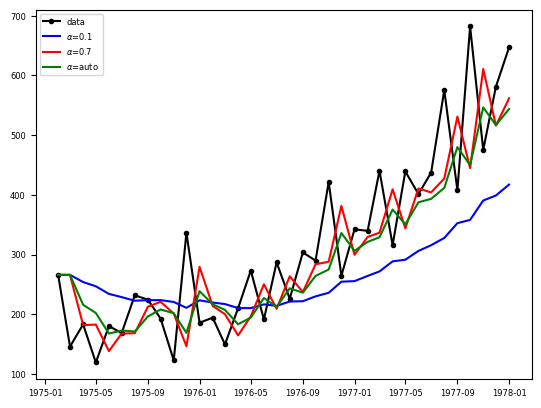

In [136]:
# Simple Exponential Smoothing #

# Plotting the original data together with the 3 forecast plots
plt.plot(series, marker=".", color="black")

## SES model 1: alpha = 0.1
fit1 = SimpleExpSmoothing(series).fit(smoothing_level=0.1,optimized=False)
fcast1 = fit1.forecast(10).rename(r'$\alpha=0.1$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit1.fittedvalues, color="blue")
#(line1,) = plt.plot(fcast1, color="blue")

## SES model 2: alpha = 0.7
fit2 = SimpleExpSmoothing(series).fit(smoothing_level=0.7,optimized=False)
fcast2 = fit2.forecast(10).rename(r'$\alpha=0.7$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit2.fittedvalues, color="red")
#(line2,) = plt.plot(fcast2, color="red")

## SES model 3: alpha automatically selected by the built-in optimization software
fit3 = SimpleExpSmoothing(series).fit()
fcast3 = fit3.forecast(10).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit3.fittedvalues, color="green")
#(line3,) = plt.plot(fcast3, color="green")

## Plot legend
plt.legend(['data', r'$\alpha$=0.1',r'$\alpha$=0.7',r'$\alpha$=auto'])

C. Cálculo dos erros dos modelos

In [137]:
#Evaluating the errors
MSE1=mean_squared_error(fit1.fittedvalues, series)
MSE2=mean_squared_error(fit2.fittedvalues, series)
MSE3=mean_squared_error(fit3.fittedvalues, series)

print('Summary of errors resulting from SES models 1, 2 & 3:')
cars = {'Model': ['MSE'],
        'SES model 1': [MSE1],
        'SES model 2': [MSE2],
        'SES model 3': [MSE3]
        }
AllErrors = pd.DataFrame(cars, columns = ['Model', 'SES model 1', 'SES model 2', 'SES model 3'])
print(AllErrors)

Summary of errors resulting from SES models 1, 2 & 3:
  Model   SES model 1  SES model 2  SES model 3
0   MSE  13349.118229  8032.361276  6878.753714


#### Exemplo 11. Série de coordenadas. Modelo de suavização exponencial
---
A. Importar o conjunto de dados

In [138]:
df_gps_north = df_gps_range[['North']].copy()

B. Estabelecer o modelo de ajuste e plotar os resultados

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

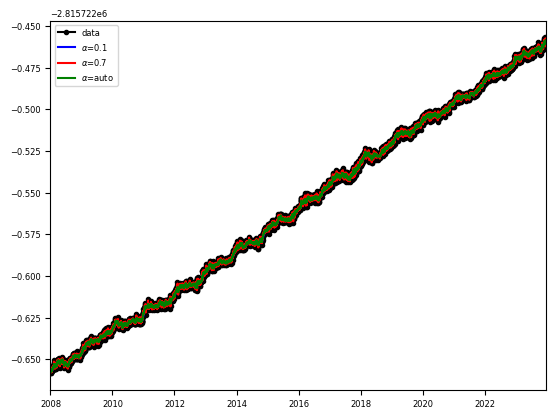

In [139]:
# Simple Exponential Smoothing #

# Plotting the original data together with the 3 forecast plots
plt.plot(df_gps_north, marker=".", color="black")

## SES model 1: alpha = 0.1
fit1 = SimpleExpSmoothing(df_gps_north).fit(smoothing_level=0.1,optimized=False)
fcast1 = fit1.forecast(10).rename(r'$\alpha=0.1$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit1.fittedvalues, color="blue")
#(line1,) = plt.plot(fcast1, color="blue")

## SES model 2: alpha = 0.7
fit2 = SimpleExpSmoothing(df_gps_north).fit(smoothing_level=0.7,optimized=False)
fcast2 = fit2.forecast(10).rename(r'$\alpha=0.7$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit2.fittedvalues, color="red")
#(line2,) = plt.plot(fcast2, color="red")

## SES model 3: alpha automatically selected by the built-in optimization software
fit3 = SimpleExpSmoothing(df_gps_north).fit()
fcast3 = fit3.forecast(10).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit3.fittedvalues, color="green")
#(line3,) = plt.plot(fcast3, color="green")

# Plot legend and axis
plt.xlim(df_gps_north.index.min(),df_gps_north.index.max())
plt.legend(['data', r'$\alpha$=0.1',r'$\alpha$=0.7',r'$\alpha$=auto'])

C. Cálculo dos erros dos modelos

In [140]:
#Evaluating the errors
from sklearn.metrics import mean_squared_error
MSE1=mean_squared_error(fit1.fittedvalues, df_gps_north)
MSE2=mean_squared_error(fit2.fittedvalues, df_gps_north)
MSE3=mean_squared_error(fit3.fittedvalues, df_gps_north)

print('Summary of errors resulting from SES models 1, 2 & 3:')
import pandas as pd
cars = {'Model': ['MSE'],
        'SES model 1': [MSE1],
        'SES model 2': [MSE2],
        'SES model 3': [MSE3]
        }
AllErrors = pd.DataFrame(cars, columns = ['Model', 'SES model 1', 'SES model 2', 'SES model 3'])
print(AllErrors)

Summary of errors resulting from SES models 1, 2 & 3:
  Model  SES model 1  SES model 2  SES model 3
0   MSE     0.000002     0.000002     0.000002


### **3.3.6. Modelos auto-regressivos integrados de médias móveis (ARIMA)**

Referência principal: analisemacro.com.br (2024)

---

A hipótese de erros não-correlacionados introduz sérias limitações na validade dos modelos de regressão, para descrever o comportamento de séries onde se conhece que os errs são auto-correlacionados.

Neste sentido, a família de modelos ARIMA constitui uma abordagem de previsão para séries temporais buscando descrever as autocorrelações dos dados.

Existem muitos modelos ARIMA sendo os 4 principais:

1. **Modelo auto-regressivo (AR)**

 Em regressão linear  buscamos modelar a relação entre uma variável dependente $y_t$ e outras variáveis independentes $x_t$, para prever $y_t$ usando uma combinação linear de $x_t$.

 De forma similar, em modelos auto-regressivos (AR) estamos interessados em prever $y_t$ com base em uma combinação linear de valores passados de $y_t$. Em outras palavras, o modelo AR é uma regressão da variável contra ela mesmo.

 A intuição por trás desse modelo é que as observações passadas da série temporal possuem uma influência ou são preditoras dos valores futuros da série.

 A forma comumente utilizada para representação desse modelo é:

  $$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$$

 onde:

 $y_t$ é a série temporal alvo de previsão.

 $c$ é a constante ou intercepto do modelo, relacionado com a média de $y_t$ porém não é a média em si.

 $\phi_p$ é o $p$ coeficiente auto-regressivo a ser estimado, geralmente restrito em intervalos que geram modelos estacionários, e

 $\epsilon_t$ é o termo de erro do modelo, um ruído branco.

 É comum se referir a esse modelo usando o acrônimo $AR(p)$, ou seja, um modelo auto-regressivo de ordem $p$, onde $p$ é a ordem de defasagens no modelo.

2. **Modelo MA**

 Em modelos de média móvel (MA) busca-se prever os valores de uma série temporal  $y_t$ com base em uma combinação linear de erros de previsão $\varepsilon_t$ passados de $y_t$. Em outras palavras, é um modelo de regressão múltipla que usa os erros passados como variáveis independentes, em vez de outras variáveis observáveis.

 A intuição por trás deste modelo é a suposição de que a variável $y_t$ reage a choques aleatórios com uma defasagem (delay), dessa forma, o choque defasado $\varepsilon_t$ é naturalmente uma variável a se colocar no modelo.

 A forma comumente utilizada para representação desse modelo é:

  $$y_{t} = c + \varepsilon_t + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q}$$

 onde:

 $\varepsilon_t$ é o termo de erro do modelo (choque), um ruído branco.

 $\theta_q$ é o q coeficiente de média móvel a ser estimado, geralmente restrito em intervalos que geram modelos invertíveis.

 É comum se referir a esse modelo usando o acrônimo $MA(q)$, ou seja, um modelo de média móvel de ordem $q$, onde $q$ é a ordem de defasagens no modelo.

3. **Modelo ARIMA**

 Em modelos auto-regressivos integrados de média móvel (ARIMA) busca-se prever os valores de uma série temporal $y_t$ com base em uma combinação linear de valores de $y_t$ e de erros de previsão $\varepsilon_t$, ambos defasados. Em outras palavras, é um modelo que combina diferenciação com os modelos auto-regressivo (AR) e de média móvel (MA).

 A única novidade em relação aos modelos anteriores é o termo de integração (I), que é o contrário de diferenciação. O termo $I$ é o número de diferenças necessárias para a série $y_t$ ser estacionária. A diferenciação é a mudança entre valores consecutivos de uma série temporal, podendo ser definida como:

  $$y'_t = y_t - y_{t-1}$$

 A estacionariedade é uma propriedade importante para esses modelos, significando que as características estatísticas (i.e., média, variância, etc.) de uma série temporal não dependem do tempo que elas foram observadas. Sendo assim, séries que apresentam tendência e sazonalidade, por exemplo, não são estacionárias.

 A intuição por trás deste modelo é explorar as autocorrelações dos dados, ou seja, a relação entre valores defasados da série temporal. Partindo de uma série estacionária, esses modelos são úteis para quando as observações passadas da série temporal, assim como choques aleatórios defasados, possuem uma influência ou são preditoras dos valores futuros da série.

 A forma comumente utilizada para representação desse modelo é:

  $$y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p} + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$$

 onde:

 $y'_t$ é a série temporal estacionária.

 É comum se referir a esse modelo usando o acrônimo $ARIMA(p,d,q)$, ou seja, um modelo auto-regressivo de ordem $p$, integrado de ordem $d$ — onde $d$ é o número de primeiras diferenças — e de média móvel de ordem $q$.

4. **Modelo SARIMA**

 Em modelos sazonais auto-regressivos integrados de média móvel (SARIMA) busca-se prever os valores de uma série temporal $y_t$ com base em uma combinação linear de valores de $y_t$ e de erros de previsão $\varepsilon_t$, ambos defasados e considerando a sazonalidade da série. Em outras palavras, é um modelo que adiciona termos sazonais para previsão da série temporal.

 Agora o modelo é composto por componentes auto-regressivos, de integração e de média móvel sazonais, além das ordens de defasagem dos componentes não sazonais, ou seja:

  $$\text{ARIMA}\underbrace{(p, d, q)}_{\text{Não sazonal}}\underbrace{(P, D, Q)_{m}}_{\text{Sazonal}}$$

 sendo:

 $_m$ a sazonalidade da série,

 a notação em caixa alta para componentes sazonais e

 a notação em caixa baixa para componentes não sazonais.

 A intuição por trás deste modelo é que as características sazonais dos dados possuem alguma influência para prever a série para o futuro. Assim as variações periódicas no tempo são utilizadas no modelo e esperadas no futuro.

 Tomando como exemplo um $ARIMA(1,1,1)(1,1,1)_4$ sem constante, a forma comumente utilizada para representação desse modelo é:

  $$(1 - \phi_{1}L)~(1 - \Phi_{1}L^{4}) (1 - L) (1 - L^{4})y_{t} = (1 + \theta_{1}L)~ (1 + \Theta_{1}L^{4})\varepsilon_{t}$$

 onde:

 $L$ é o operador de defasagem, ou seja, $L$ operando em $y_t$ tem o efeito de defasar a série em um período $(L y_{t} = y_{t - 1})$.

 $\Phi_1$ é o coeficiente auto-regressivo sazonal a ser estimado.

 $\Theta_1$ é o coeficiente de média móvel sazonal a ser estimado.

 Os termos sazonais estão sendo multiplicados pelos termos não sazonais.

**Importante:**

A estimação dos coeficientes dos diferentes modelos pode ser feita pela máxima verossimilhança (MLE), que é uma técnica para encontrar os valores para os coeficientes que maximizam a probabilidade de obter os dados que foram observados.

#### Exemplo 12. Série de terremotos. Modelo ARIMA
A. Importar o conjunto de dados

In [141]:
earthquake = pd.read_csv('/content/timeseries/datasets/anhhaibkhn/earthquakes.csv', usecols=['date', 'earthquakes_per_year'], parse_dates=['date'])

earthquake.head()

,date,earthquakes_per_year
0,1900-01-01,13.0
1,1901-01-01,14.0
2,1902-01-01,8.0
3,1903-01-01,10.0
4,1904-01-01,16.0


B. Plotar os dados

In [142]:
# Ativar "plotly" para geração de gráficos interativos
pd.options.plotting.backend = "plotly"

# Geração da série de coordenadas
fig = earthquake.plot(title = "Major earthquakes (magnitude 7.0 or greater) per year (1900-2000)", x = 'date', y = 'earthquakes_per_year')

# Apresentar série de tempo
fig.show()

C. Análise de estacionariedade (Teste de Breusch-Pagan)

In [143]:
df_model = ols(formula='earthquakes_per_year~date', data=earthquake).fit()

model_earth = test_model(earthquake['earthquakes_per_year'])

bp_test = het_breuschpagan(df_model.resid, model_earth)

print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
0.6389585382110158


**Interpretação:**

O resultado do *valor p* do teste é maior que o nível de significância, portanto podemos aceitar $H_0$ (i.e. os dados são homocedásticos).

D. Analise e seleção do modelo

D.1. Utilizando as funções de autocorrelação (ACF) e autocorrelação parcial (PACF)

Ver documento: **[Modelación ARIMA](http://www.ptolomeo.unam.mx:8080/jspui/bitstream/132.248.52.100/363/7/A7.pdf)**

<center><img src=https://iili.io/dtsDTJI.png width="1000"></center>

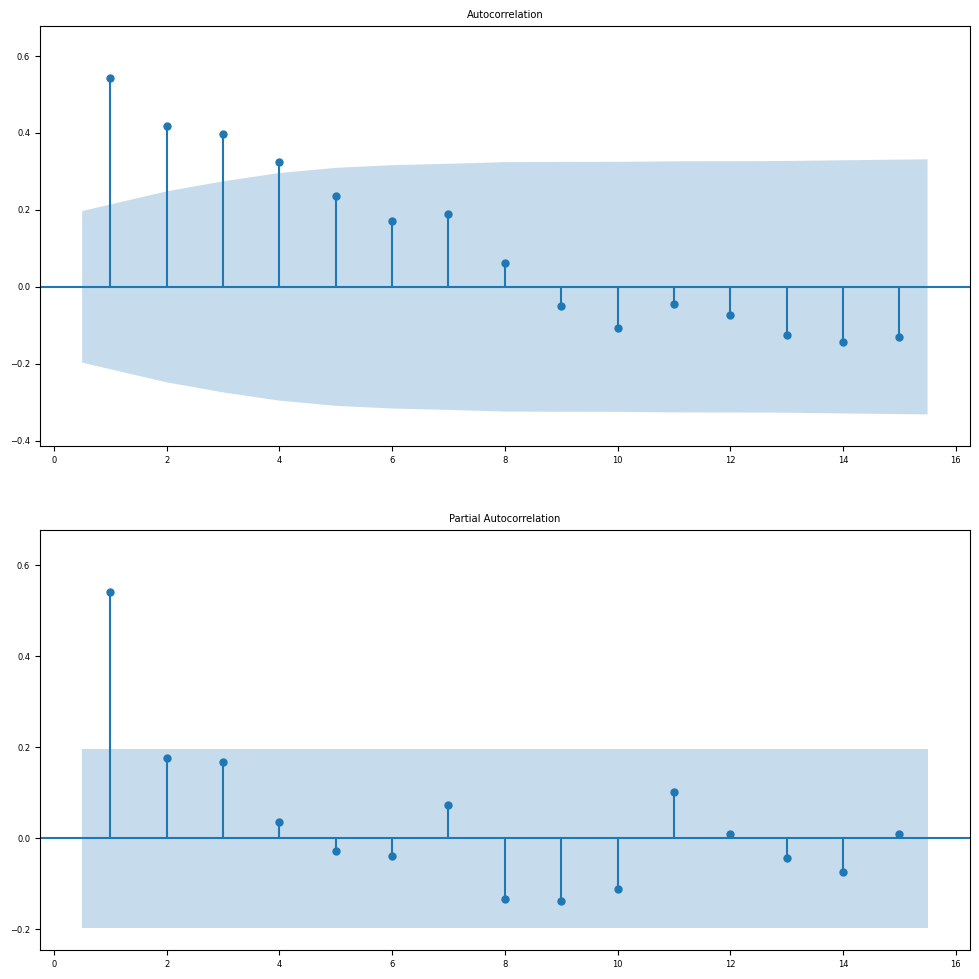

In [144]:
# Importar os dados sem indexador
earthquake = pd.read_csv('/content/timeseries/datasets/anhhaibkhn/earthquakes.csv', usecols=['date', 'earthquakes_per_year'], parse_dates=['date'], index_col=[0])

# Criar figura
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))

# Plotar ACF e PACF (sem lag 0)
plot_acf(earthquake, lags=15, zero=False, ax=ax1, auto_ylims=True)
plot_pacf(earthquake, lags=15, zero=False, ax=ax2, auto_ylims=True)

# Apresentar figura
plt.show()

**Interpretação:**

Analisando as figuras de Autocorrelação Total e Parcial, é possivel ver que o melhor modelo para a série é um modelo do Tipo AR(1).

D.2. Utilizando os criterios AIC (critério de informação de Akaike) e BIC (Critério de informação Bayesiano de Schwartz)

**Importante:**

* AIC e BIC são dois critérios que medem a qualidade de ajuste de um modelo estatístico, levando em conta tanto a complexidade quanto a acurácia do modelo
* Ambos os critérios são baseados na função de verossimilhança, que quantifica o quão bem o modelo se ajusta aos dados, e penalizam o modelo por ter mais parâmetros, o que aumenta o risco de sobreajuste.
* Quanto menor o AIC ou BIC, melhor o modelo.

D.2.1. Testar modelos até ordem 2 (p e q)

In [145]:
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
        # Create and fit ARMA(p, q) model
        model = SARIMAX(earthquake, order=(p, 0, q))
        results = model.fit()

        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency informat

D.2.2. Imprimir resultados - Criterio de Akaike

In [146]:
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

   p  q         AIC         BIC
4  1  1  647.132300  654.917660
5  1  2  648.738566  659.119046
7  2  1  648.842840  659.223319
8  2  2  648.850644  661.826244
6  2  0  656.028374  663.813734
3  1  0  666.645526  671.835765
2  0  2  761.067479  768.852838
1  0  1  799.674173  804.864412
0  0  0  888.429772  891.024892


D.2.3. Imprimir resultados - Criterio Bayesiano

In [147]:
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q         AIC         BIC
4  1  1  647.132300  654.917660
5  1  2  648.738566  659.119046
7  2  1  648.842840  659.223319
8  2  2  648.850644  661.826244
6  2  0  656.028374  663.813734
3  1  0  666.645526  671.835765
2  0  2  761.067479  768.852838
1  0  1  799.674173  804.864412
0  0  0  888.429772  891.024892


**Interpretação:**

Analisando os critérios AIC e BIC, é possivel ver que o melhor modelo para a série é o modelo do Tipo ARMA(2,1).

E. Construção do modelo

In [148]:
# Instantiate model
model = SARIMAX(earthquake, order=(1, 0, 1))

# Train model
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



F. Avaliar o modelo

F.1. Utilizando o MAE (Erro absoluto médio)

**Importante:**

O MAE mede a média da diferença absoluta entre os valores previstos pelo modelo e os valores observados.

In [149]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

4.755625669941166


**Interpretação:**

O MAE é perto dos 4 ou 5 terremotos por ano. Considerando que por ano acontecem aproximadamente 20 terremotos em médio, o modelo não é tão ruim.

F.2. Utilizando os testes de Ljung-Box e Jarque-Bera

<center><img src=https://iili.io/dtbrjNn.png width="1000"></center>

In [150]:
# Print summary
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                 SARIMAX(1, 0, 1)   Log Likelihood                -320.566
Date:                  Tue, 01 Oct 2024   AIC                            647.132
Time:                          00:18:47   BIC                            654.918
Sample:                      01-01-1900   HQIC                           650.282
                           - 01-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9893      0.014     70.282      0.000       0.962       1.017
ma.L1         -0.5517      0.089     -6.198      0.000      -0.726      -0.377
sigma2        37.0254      4.980    

**Interpretação:**

* Não existe correlação entre os resíduos.
* Os resíduos estão normalmente distribuídos


## **3.4. Filtros**

Em termos gerais, a análise de séries temporais é usada para:

* Descrever as escalas de tempo nas quais os dados variam, e
* Identificar as escalas de tempo que respondem pela maior contribuição para a variância.

Por exemplo, uma tendência de longo prazo pode ser responsável pela maior parte da variabilidade em uma determinada série temporal ou o ciclo sazonal pode ser a maior fonte da variabilidade em uma série temporal diferenciada (transformada).

Neste sentido, um conceito-chave na análise de séries temporais é a filtragem. A filtragem é uma técnica que pode ser usada para remover ruído de alta frequência ou variabilidade de baixa frequência de séries temporais e isolar as frequências de interesse.

### **3.4.1. Aplicações**

Entre os principais motivos pelos quais uma série é filtrada estão:

* Quando uma série temporal original possui alta autocorrelação e é necessário remover a fonte de dita autocorrelação (por exemplo, uma tendência, um ciclo sazonal ou diurno, entre outros).
* Existe o interesse apenas em uma determinada característica de uma série temporal e é necessario isolar as frequências relevantes (por exemplo, ENSO)

### **3.4.2. Tipos de Filtros**

Dependendo do tipo de variabilidade que possui a série, existem 3 tipos de filtros que podem ser utilizados. Estes são:

* **Filtragem passa-baixa (low-pass filtering):** retém apenas a variabilidade de baixa frequência (também conhecida como "suavização").
* **Filtragem passa-alta (high-pass filtering):** retém apenas a variabilidade de alta frequência
* **Filtragem passa-banda (band-pass filtering):** retém uma "banda" de frequências

<center><img src=https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/_images/NASAGISTEMP.png width="600"></center>

  <center>Figura 05. Série temporal da temperatura superfícial com média global (GISTEMP) em resolução temporal anual (curva preta). A curva vermelha mostra a série temporal filtrada de passa-baixa usando a técnica Lowess smoothing</center>

  <center>Fonte: Smith, K. (2024)</center>

#### Exemplo 13. High-Pass Filtering. Tendência de longo prazo. Temperatura da troposfera.
---

Como discutimos anteriormente, a presença de autocorrelação em uma série temporal significa que os dados não são independentes e que o tamanho da amostra é superestimada. A autocorrelação geralmente é o resultado de uma tendência de longo prazo. Então, uma maneira de contornar isso é remover a tendência de longo prazo.

A. Importar os dados

In [153]:
# set default font size and weight for plots
mpl.rc('font',size=14,weight='bold')

# Read in TLT file
filename = '/content/timeseries/datasets/smith/TLT_19792019.txt'
T = np.squeeze(np.genfromtxt(filename, delimiter=','))

# Extract Dec. 1979 - November 2019 and just extract last column (temperature data)
T = T[11:-1,2]

# Alternative way to compute the seasonal averages
T_seasons = np.mean(T.reshape(-1, 3), axis=1)

B. Plotar os dados

Text(0.5, 1.0, 'Seasonal TLT Time Series (1980-2019)')

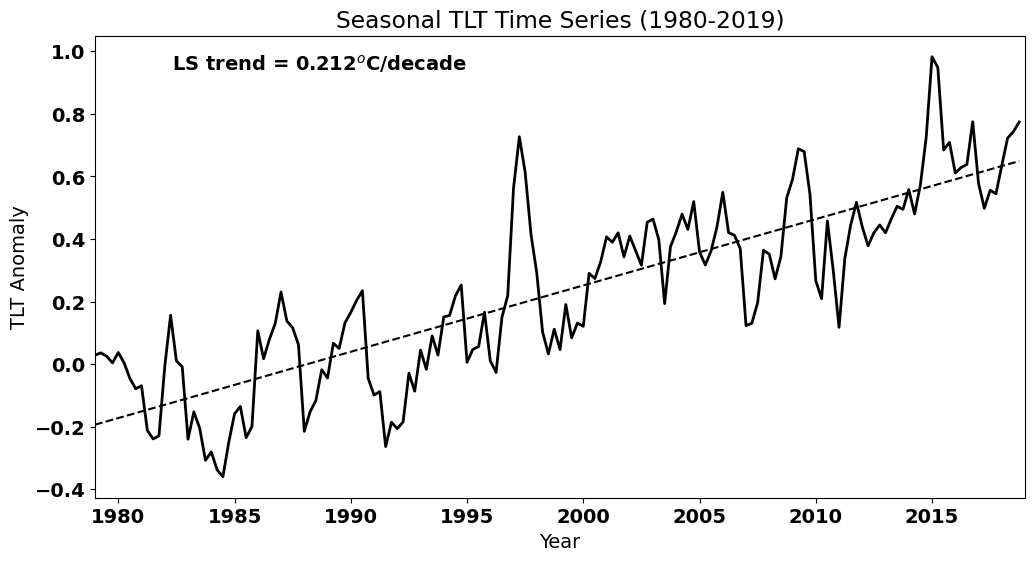

In [154]:
# Create time index for plotting and for regression
time = np.arange(0,len(T_seasons),1)

# Plot the data
plt.figure(figsize=(12,6))

# plot time series
plt.plot(time,T_seasons,'k',linewidth=2)

# calculate best-fit line
a = np.polyfit(time,T_seasons,1)
T_hat = np.polyval(a,time)

# plot best-fit line
plt.plot(time,T_hat,'k',linestyle='--')

# ticks, labels, etc.
plt.xticks(np.arange(4,len(time),20),["1980","1985","1990","1995","2000","2005","2010","2015"])
plt.xlim(0,len(time))
plt.text(0.4, 0.925,'LS trend = ' + str(np.round(a[0]*40,3)) + '$^o$C/decade', ha='right', transform=plt.gca().transAxes, color = 'k') # we multiply by 40 because our unit of time is seasons but we want to report the trend in deg C per decade
plt.ylabel("TLT Anomaly")
plt.xlabel("Year")
plt.title("Seasonal TLT Time Series (1980-2019)")

C. Filtragem do termo de longo prazo (Eliminação da tendência da série)

In [157]:
# detrend the TLT temperature time series
T_dtr = T_seasons - T_hat

# We need to find the covariance of the deviations from the mean and then divide the tau=0 covariance (i.e. the variance to get the correlation)
Tcorr = np.correlate((T_seasons-np.mean(T_seasons)),(T_seasons-np.mean(T_seasons))/(len(T_seasons)*np.var(T_seasons)),'same')
Tcorr_dtr = np.correlate((T_dtr-np.mean(T_dtr)),(T_dtr-np.mean(T_dtr))/(len(T_dtr)*np.var(T_dtr)),'same')

D. Cálculo e plotagem das funções de autocorrelação

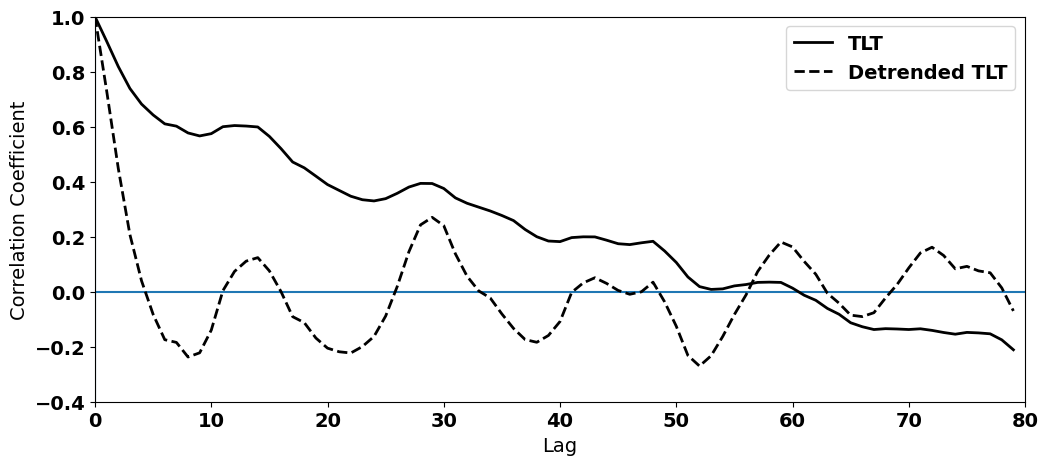

In [158]:
#plot the autocorrelation function
fig = plt.figure(figsize=(12,5))

# x-value for plotting
x = np.arange(0,len(T_seasons),1)
series = [i-len(T_seasons)/2.0 for i in x]

#plot series
plt.axhline(0)
plt.axvline(0)
plt.plot(series[int(len(T_seasons)/2):],Tcorr[int(len(T_seasons)/2):],'k',linewidth=2,label="TLT")
plt.plot(series[int(len(T_seasons)/2):],Tcorr_dtr[int(len(T_seasons)/2):],'k--',linewidth=2,label="Detrended TLT")
plt.xlim(0,80)
plt.ylim(-0.4,1)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag')
plt.legend(loc='upper right')

#### Exemplo 14. Band-Pass Filtering. Ciclo sazonal. Camadas de gelo do Artico (SIE GCM)
---

Uma característica de muitas variáveis gedésicas e geofísicas que resulta em autocorrelação é o ciclo sazonal. Neste sentido, resulta importante remover o ciclo sazonal a fim de reduzir a autocorrelação.

Seja:

$$ x'_{t}\left ( t \right )=x_{i}\left ( t \right )-\bar{x}$$

as anomalias obtidas para cada elemento $i$ em uma série temporal, $i=0,\cdots ,N$.

Em outras palavras, define-se como anomalia o desvio da média temporal.

Mas, a média temporal não é tão significativa quando temos um grande ciclo sazonal. Neste caso, alternativamente, podemos definir as anomalias subtraindo a média temporal sazonal para cada dia ou mês do ano. Isto é:

$$x'_{ij}\left ( t \right )=x_{ij}\left ( t \right )-\bar{x_{j}}$$

onde $i$ é o ano e $j$ é o dia do ano (para dados com resolução temporal diária).

Assim, $\bar{x_{j}}$ representa a média temporal do ciclo sazonal.

Se subtrairmos isso, então devemos ficar com toda a variabilidade que não está associada a este ciclo sazonal da média temporal.

<center><img src=https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/_images/anomaly.png width="700"></center>

<center>Figura 06. Extensão do gelo marinho do Ártico. Os pontos representam o 1º de janeiro de cada ano e a linha preta em horizontal a média de todos eles</center>

<center>Fonte: Smith, K. (2024)</center>

A. Importar os dados

In [162]:
# Read in Arctic SIE data
fname = '/content/timeseries/datasets/smith/SIE_Total.pickle'
with open(fname,'rb') as fp:
    sie,lat,lon = pickle.load(fp, encoding = 'iso8859')

# print shape of data
print(sie.shape)

(400, 365)


B. Reamostragem da série

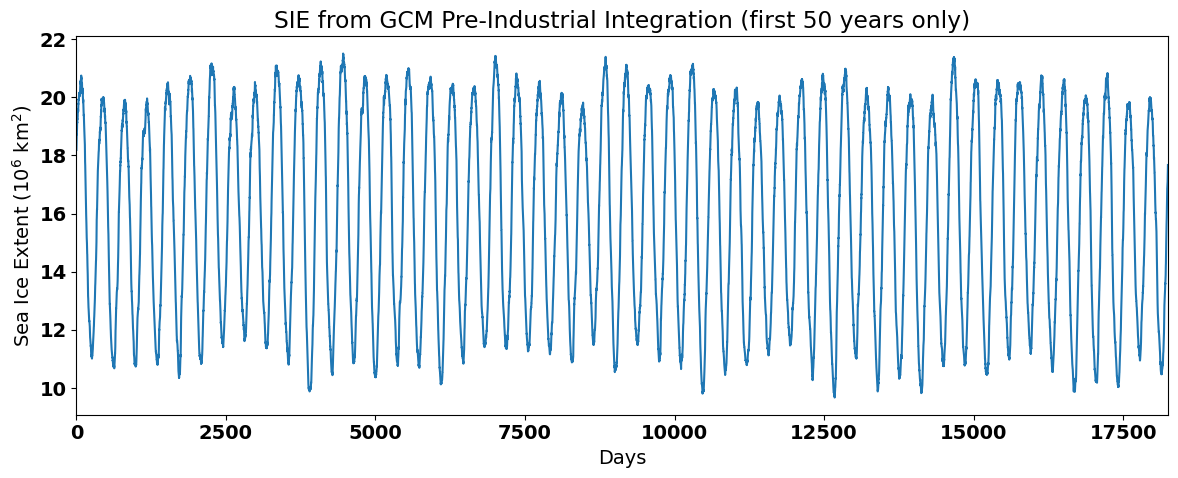

In [164]:
# Convert sie to time series
# I'm using np.ravel() but you can also use np.reshape()
sie_ts = np.ravel(sie)

# plot Arctic SIE time series to show the seasonal cycle
plt.figure(figsize=(12,5))

# this data consists of 400 years of daily data, but here I am just plotting 50 years
plt.plot(sie_ts[0:50*365]/1e12) # divide by 10**12 for plotting
plt.xlim(0,50*365)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('SIE from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

C. Cálculo da média mensal para o periodo de estudo

(365,)


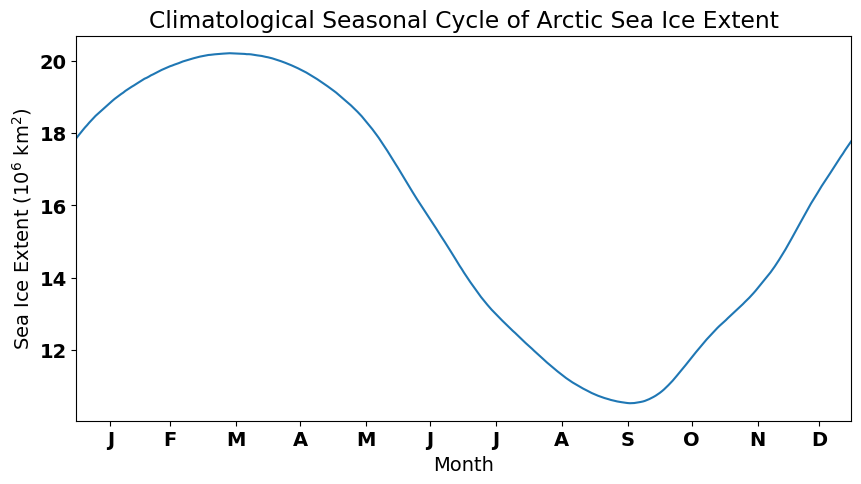

In [166]:
# Take the average over all years to get a 365-day climatology.
sie_clim = np.mean(sie,axis=0)

print(sie_clim.shape)

# Plot the seasonal cycle
plt.figure(figsize=(10,5))
plt.plot(sie_clim/1e12)
plt.xlim(0,364)
plt.xticks([16,44,75,105,136,166,197,228,259,289,320,349],
           ["J","F","M","A","M","J","J","A","S","O","N","D"])
plt.xlabel("Month")
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('Climatological Seasonal Cycle of Arctic Sea Ice Extent')
plt.show()

D. Filtragem do ciclo sazonal da série original

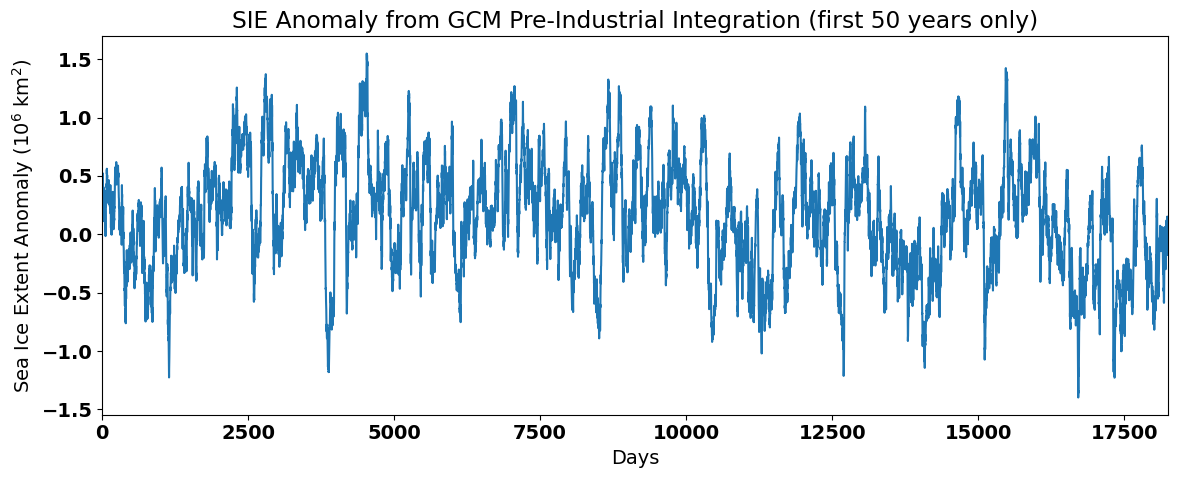

In [168]:
# Remove the 400-year time mean for each day from each day and convert to a long time series again.
sie_anom = sie - sie_clim
sie_deseason1 = np.ravel(sie_anom)

# plot the SIE anomaly
plt.figure(figsize=(12,5))
plt.plot(sie_deseason1[0:50*365]/1e12)
plt.xlim(0,50*365)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent Anomaly (10$^6$ km$^2$)')
plt.title('SIE Anomaly from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

**Interpretação:**

* Observe que a magnitude das anomalias é bem pequena comparada à magnitude do ciclo sazonal.
* Os dados parecem mais ruidosos e não exibem um ciclo sazonal, mas mostram algumas flutuações decadais.
* Ao remover o ciclo sazonal usando este método, filtramos a série temporal por passagem de banda (band-pass filter), deixando para trás a variabilidade em frequências mais altas e mais baixas do que o ciclo sazonal.

#### Exemplo 15. Low-Pass Filtering. Ciclo sazonal da média móvel. Camadas de gelo do Artico (SIE GCM)
---

O método acima apresentado para remover o ciclo sazonal é o mais comum na literatura de ciência climática, mas pode não ser sempre apropriado, por exemplo, se a magnitude do ciclo sazonal muda consistentemente em função do tempo.

Os filtros de média móvel permitem filtrar os dados de forma passa-baixa, calculando a média em um intervalo de tempo específico.

Um exemplo de um filtro de média móvel para $L = 3$ é:

$$ y\left ( t \right )=\frac{1}{3}x\left ( t-1 \right )+\frac{1}{3}x\left ( t \right )+\frac{1}{3}x\left ( t+1 \right )$$

onde $y\left ( t \right )$ é a série temporal filtrada.

Da mesma forma, um filtro de média móvel com $L = 5$ pode ser representado da seguinte forma:

$$ y\left ( t \right )=\frac{1}{5}x\left ( t-2 \right )+\frac{1}{5}x\left ( t-1 \right )+\frac{1}{5}x\left ( t \right )+\frac{1}{5}x\left ( t+1 \right )+\frac{1}{5}x\left ( t+2 \right )$$

Se estivermos interessados ​​em remover o ciclo sazonal usando um filtro de média móvel, então precisamos escolher
$L$, de modo que estejamos suavizando o ciclo sazonal.

Desta maneira, para dados mensais podemos dizer que $L = 12$ e para dados diários $L = 365$.

Aplicando tal filtro, terminamos com uma série temporal suavizada, com o ciclo sazonal removido.

A. Criação do filtro

A.1. Criação de uma função para eliminação da média movel

In [169]:
# We can remove the seasonal mean using a 365-day running mean

# initialize array
sie_deseason2 = np.array(np.mean(sie_ts[0:365]))

# Here is the code from scratch
# Loop over elements of sie_ts and compute centred 365-day average each time
for i in range(183,400*365-182):
    sie_deseason2 = np.append(sie_deseason2,np.mean(sie_ts[i-182:i+183]))

A.2. Filtro usando convolução

In [171]:
# Here is a nice python package that does the same thing as the code above
sie_deseason3 = np.convolve(sie_ts,np.ones((365,))/365.0,mode='valid')

B. Apresentação de resultados

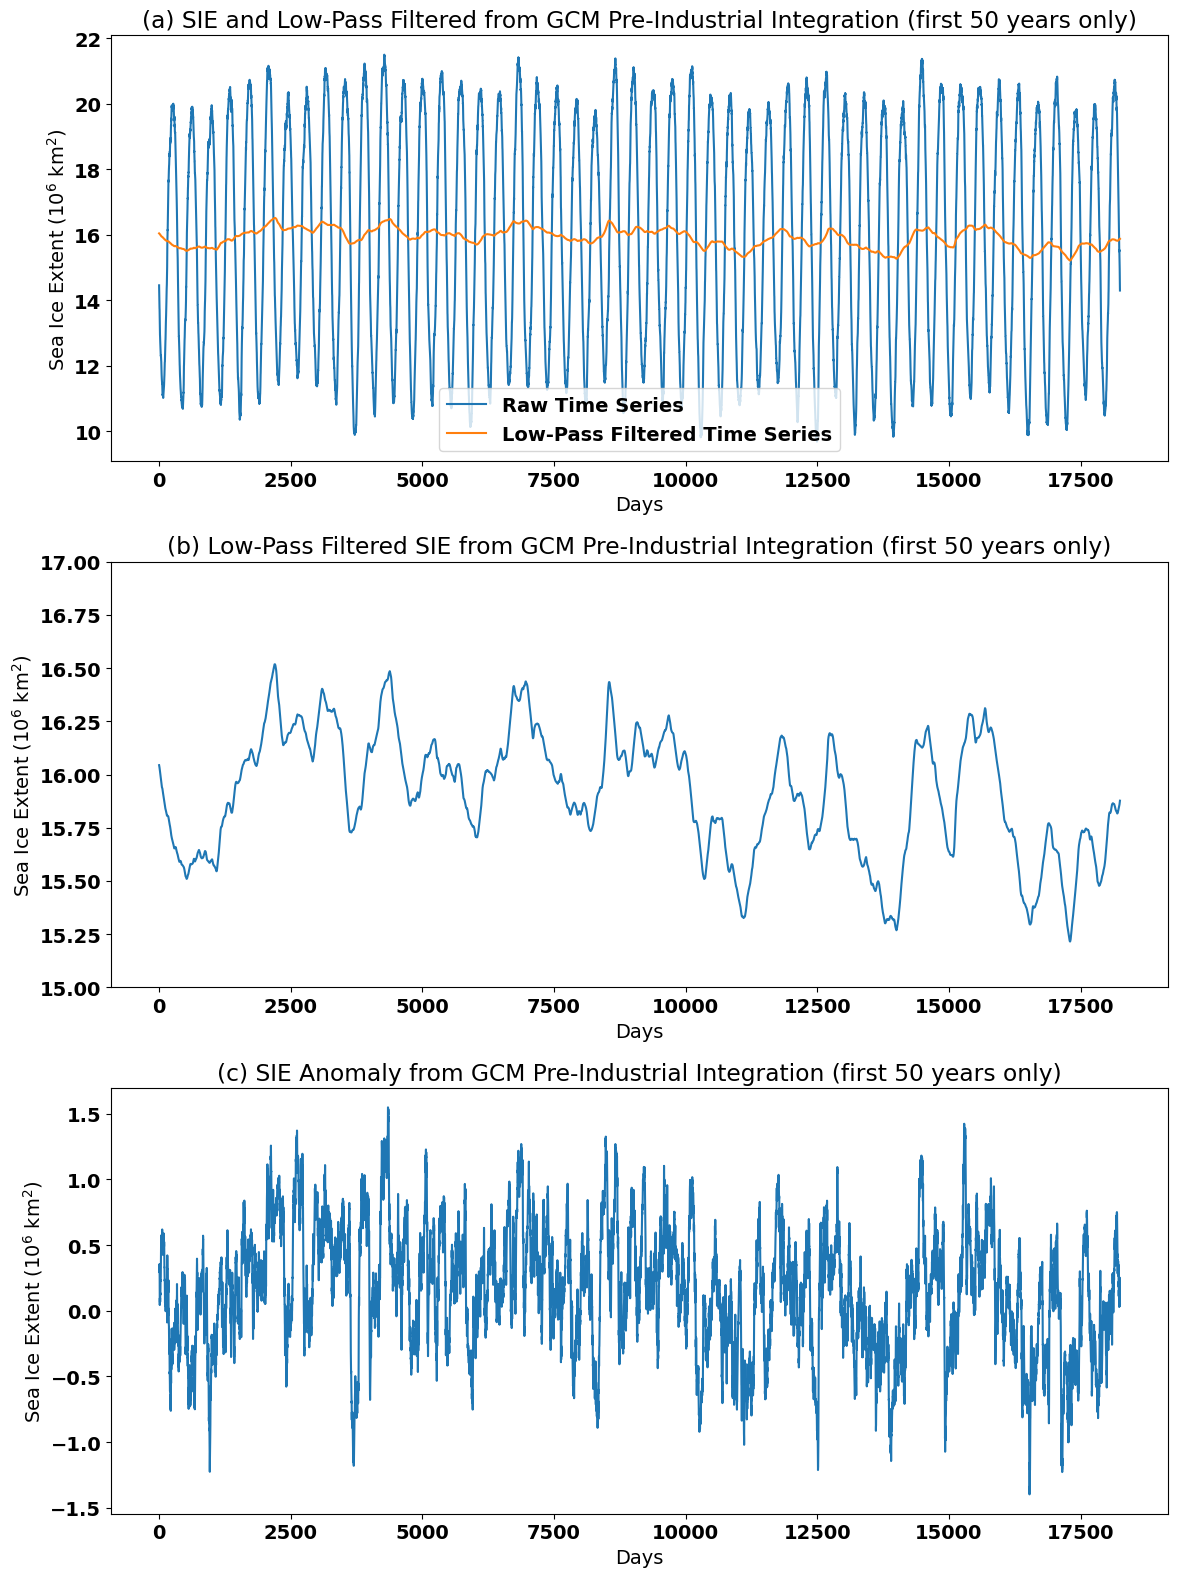

In [172]:
# Plot raw and running-mean filtered time series
plt.figure(figsize=(12,16))
plt.subplot(3,1,1)
plt.plot(sie_ts[182:50*365+182]/1e12, label = "Raw Time Series") # note that the start index is 182 to match the running-mean filter
plt.plot(np.asarray(sie_deseason3[0:50*365])/1e12, label="Low-Pass Filtered Time Series")
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(a) SIE and Low-Pass Filtered from GCM Pre-Industrial Integration (first 50 years only)')
plt.legend()
plt.tight_layout()

# Plot just the running-mean filtered time series
plt.subplot(3,1,2)
plt.plot(np.asarray(sie_deseason3[0:50*365])/1e12)
plt.ylim(15,17)
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(b) Low-Pass Filtered SIE from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

# Plot anomaly time series using Method 1
plt.subplot(3,1,3)
plt.plot(sie_deseason1[182:50*365+182]/1e12) # note that the start index is 182 to match the running-mean filter
plt.xlabel('Days')
plt.ylabel('Sea Ice Extent (10$^6$ km$^2$)')
plt.title('(c) SIE Anomaly from GCM Pre-Industrial Integration (first 50 years only)')
plt.tight_layout()

**Interpretação:**

* É possivel ver claramente que o ciclo sazonal foi suavizado da série temporal SIE. De fato, a variabilidade em frequências iguais e também maiores que
$L = 365$ dias foi suavizada.
* A série temporal filtrada por média móvel exibe variabilidade principalmente em frequências mais baixas.

**Importante:**

A. Relação entre filtros

Para encontrar a componente filtrada passa-alta, pode simplesmente subtrair a componente filtrada passa-baixa do original:

$$y\left ( t \right )_{high-pass}=y\left ( t \right )-y\left ( t \right )_{low-pass}$$

Por sua vez, um filtro passa-banda pode ser obtido subtraindo uma série temporal filtrada passa-baixa de outra com um corte em uma frequência mais alta:

$$y\left ( t \right )_{band-pass}=y\left ( t \right )_{L\geq T_{1}}-y\left ( t \right )_{L\geq T_{2}}$$

onde $T_{1}\leq T_{2}$.

B. Variações em filtros de média móvel

Observe que os filtros de média móvel assumem que cada ponto em $L$ é ponderado igualmente; no entanto, os filtros de média móvel podem ser melhorados alterando essa suposição (Por exemplo, um filtro gaussiano assume que os pontos em $L$ são ponderados seguindo uma distribuição gaussiana).